<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
This notebook plots RNAseq misc. results

</div>



In [1]:
import os
import urllib.request

output_dir = "../../bulkRNAseq/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

urls = ['https://storage.googleapis.com/abca7lof/241121Tsa/abca7_rna_seq_metadata_with_seqIDs.csv',
'https://storage.googleapis.com/abca7lof/241121Tsa/counts.txt']

for url in urls:
    local_filename = os.path.join(output_dir, os.path.basename(url))
    urllib.request.urlretrieve(url, local_filename)
    print("Download completed!")

Download completed!
Download completed!


In [3]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import stack_data  # Adjust this to your module's data-loading function


In [23]:

# load data
counts = pd.read_csv('../../bulkRNAseq/counts.txt', delimiter='\t', comment="#")
metadata = pd.read_csv('../../bulkRNAseq/abca7_rna_seq_metadata_with_seqIDs.csv')
metadata['SeqID'] = metadata['SeqID'].str.strip()
metadata[(metadata['Notes'].str.contains('batch 1')) & (metadata['Treatment']=='H20')]['Line'].value_counts()

Line
Y622       5
G2         5
Control    2
Name: count, dtype: int64

In [24]:
# get counts
sam_columns = [col for col in counts.columns if col.endswith('.sam')]
counts_extracted = counts[sam_columns]
new_column_names = {col: col.split('_')[1].split('Aligned')[0] for col in counts_extracted.columns}
counts_extracted.rename(columns=new_column_names, inplace=True)
counts_sums = counts_extracted.sum(axis=0)
counts_cpm = counts_extracted.div(counts_sums, axis=1) * 1e6 


names = set(counts['gene_name'][counts['gene_type']=='protein_coding'])
index = counts['gene_type']=='protein_coding'
counts_cpm_protein_coding = counts_cpm[index]
counts_cpm_protein_coding.index = counts['gene_name'][index]
counts_cpm_protein_coding = counts_cpm_protein_coding.iloc[:, 1:]


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_87645/1389774987.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_extracted.rename(columns=new_column_names, inplace=True)


Control vs. Y622: Custom statistical test, P_val:7.100e-03
Control vs. G2: Custom statistical test, P_val:9.496e-02


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator

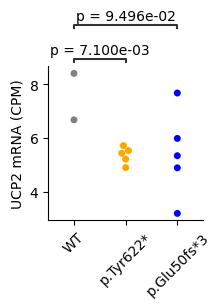

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

gene = 'UCP2'

plt.figure(figsize=(2, 2))
# Select data for batch 1 and H20 treatment
batch_1_seqids = metadata[metadata['Notes'].str.contains('batch 1')]['SeqID']
line_seqids = metadata[metadata['Treatment'] == 'H20']['SeqID']
common_seqids = np.intersect1d(batch_1_seqids, line_seqids)
counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding.loc[:, common_seqids]

# Create a DataFrame for gene ABCA7; assume gene names are in the index
x = pd.DataFrame(counts_cpm_protein_coding_batch_1.loc[gene])
x['SeqID'] = x.index

# Merge with metadata on 'SeqID'
merged = pd.merge(x, metadata, on='SeqID')

# Create a swarmplot of ABCA7 expression by Line
#sns.boxplot(x='Line', y=gene, data=merged, hue='Line')
ax = sns.swarmplot(x='Line', y=gene, data=merged, hue='Line',
                   palette={'Control': 'grey', 'Y622': 'orange', 'G2': 'blue'})

# Define pairs to compare (adjust these as needed)
pairs = [('Control', 'Y622'), ('Control', 'G2')]
# Define the order of the groups; for example, if you want "Control", "Y622", then "G2"
order = ['Control', 'Y622', 'G2']

# Create and configure the Annotator with precomputed p-values
pvalues = [data1.loc['UCP2']['P.Value'], data3.loc['UCP2']['P.Value']]  # Example p-values for the pairs
annotator = Annotator(ax, pairs, data=merged, x='Line', y=gene, order=order)
annotator.set_pvalues(pvalues)
annotator.configure(text_format='full', loc='outside', verbose=2, show_test_name=False)
annotator.annotate()

plt.legend([], [], frameon=False)
# Change x axis ticks labels
ax.set_xticklabels(['WT', 'p.Tyr622*', 'p.Glu50fs*3'], rotation=45)
ax.set_xlabel('')
ax.set_ylabel('UCP2 mRNA (CPM)')
# Remove top and right plot borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('../../paper/extended_plots/UCP_levels.png', dpi=300, bbox_inches='tight')
plt.show()


0.094962035274728

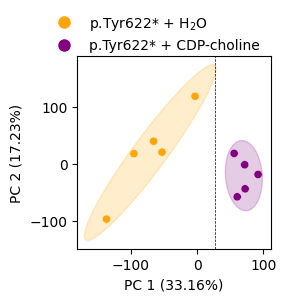

In [42]:
# show PCA; treatment batch 1
batch_1_seqids = metadata[metadata['Notes'].str.contains('batch 1')]['SeqID']
line_seqids = metadata[metadata['Line'] == 'Y622']['SeqID']
counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding[np.intersect1d(batch_1_seqids, line_seqids)]

# Perform PCA on the counts_cpm_protein_coding
scaler = StandardScaler()
counts_cpm_protein_coding_scaled = scaler.fit_transform(counts_cpm_protein_coding_batch_1.T)
pca = PCA(n_components=4)
principal_components = pca.fit_transform(counts_cpm_protein_coding_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['SeqID'] = counts_cpm_protein_coding_batch_1.columns
pca_df = pd.merge(pca_df, metadata, on='SeqID')

pca_df['grp'] = pca_df['Treatment'] + '_' + pca_df['Line']
# plot results
plt.figure(figsize=(2.5, 2.5))
sns.scatterplot(x='PC1', y='PC2', hue='grp', data=pca_df, palette={'H20_Control': 'grey', 'H20_Y622': 'orange', 'Choline2Weeks_Y622': 'purple'}, edgecolor='w')

pca_df['grp'] = pca_df['Treatment'] + '_' + pca_df['Line']
#Add confidence ellipses for each group
import matplotlib.patches as patches
for treatment in pca_df['grp'].unique():
    line_data = pca_df[pca_df['grp'] == treatment]
    confidence_ellipse = np.cov(line_data['PC1'], line_data['PC2'])
    eigenvals, eigenvecs = np.linalg.eig(confidence_ellipse)
    angle = np.degrees(np.arctan2(eigenvecs[1,0], eigenvecs[0,0]))
    
    ellipse = patches.Ellipse(xy=(line_data['PC1'].mean(), line_data['PC2'].mean()),
                            width=2*np.sqrt(eigenvals[0])*2,
                            height=2*np.sqrt(eigenvals[1])*2,
                            angle=angle,
                            fill=True,
                            alpha=0.2,
                            color='orange' if treatment=='H20_Y622' else 'purple')
    plt.gca().add_patch(ellipse)

explained_variance = pca.explained_variance_ratio_
plt.xlabel(f'PC 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]*100:.2f}%)')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
# Remove the existing legend
plt.legend([],[], frameon=False)

# Add a custom legend based on marker type
from matplotlib.lines import Line2D


legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='orange', markersize=10,linestyle='None', label=r'p.Tyr622* + H$_2$O'),
    Line2D([0], [0], marker='o', markerfacecolor='purple',color='w',
           markersize=10, linestyle='None', label='p.Tyr622* + CDP-choline')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(.4, 1.28), loc='upper center', frameon=False)
# Add vertical line along the mean of PC1
mean_pc1 = pca_df['PC1'].median()
plt.axvline(x=mean_pc1, color='black', linestyle='--',  linewidth=0.5)

plt.savefig('../../paper/main_plots/pca_rna_batch1.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# load DEGs
data1 = pd.read_csv('../../bulkRNAseq/y622_degs.csv', index_col=0)
data2 = pd.read_csv('../../bulkRNAseq/choline_degs.csv', index_col=0)
data3 = pd.read_csv('../../bulkRNAseq/g2_degs.csv', index_col=0)
data4 = pd.read_csv('../../bulkRNAseq/choline_batch2_degs.csv', index_col=0)

data1.head()
data2.head()
data1.index = data1['genes']
data2.index = data2['genes']
data3.index = data3['genes']
data4.index = data4['genes']
data1['score'] = -np.log10(data1['P.Value']) * np.sign(data1['logFC'])
data2['score'] = -np.log10(data2['P.Value']) * np.sign(data2['logFC'])
data3['score'] = -np.log10(data3['P.Value']) * np.sign(data3['logFC'])
data4['score'] = -np.log10(data4['P.Value']) * np.sign(data4['logFC'])

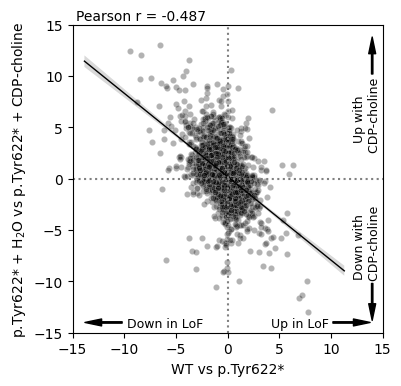

In [49]:
# show correlation of scores between CDP-choline and LoF

data_merged = pd.merge(data1, data2, left_index=True, right_index=True)

plt.figure(figsize=(4, 4))

# Create a random subsample (e.g., 10% of the points)
sample_df = data_merged.sample(frac=0.2, random_state=42)

# Plot the regression line using the full dataset without scatter points
sns.regplot(x='score_x', y='score_y', data=data_merged, scatter=False, ci=95, color='black', line_kws={'linewidth': 1})

# Overlay scatter points from the subsample
sns.scatterplot(x='score_x', y='score_y', data=sample_df, color='black', alpha=0.3, s=20)

# Calculate Pearson correlation coefficient and p-value
r, p = stats.pearsonr(data_merged['score_x'], data_merged['score_y'])

# Add text annotation with the correlation coefficient
plt.text(0.01, 1.05, f'Pearson r = {r:.3f}',
         transform=plt.gca().transAxes, verticalalignment='top')

# Add horizontal and vertical dotted lines at zero
plt.axhline(y=0, color='grey', linestyle='dotted')
plt.axvline(x=0, color='grey', linestyle='dotted')

plt.xlabel('WT vs p.Tyr622*')
plt.ylabel('p.Tyr622* + H$_2$O vs p.Tyr622* + CDP-choline')
# Add arrow in lower right quadrant
plt.annotate('', xy=(14, -14), xytext=(10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(7, -14.5, 'Up in LoF', ha='center', fontsize=9)

plt.annotate('', xy=(-14, -14), xytext=(-10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-6, -14.5, 'Down in LoF', ha='center', fontsize=9)

plt.annotate('', xy=(14, 14), xytext=(14, 10),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(13.5, 2.5, 'Up with \n CDP-choline', ha='center', fontsize=9, rotation=90)

plt.annotate('', xy=(14, -14), xytext=(14, -10),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(13.5, -10, 'Down with \n CDP-choline', ha='center', fontsize=9, rotation=90)


plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.savefig('../../paper/main_plots/rna_correlation_plot.png', bbox_inches='tight')

plt.show()


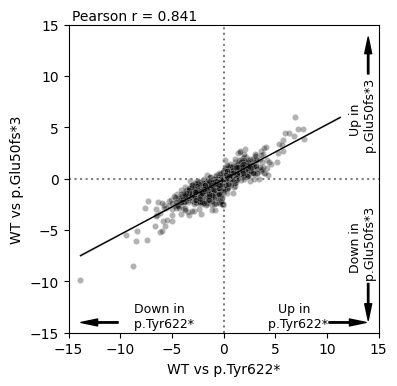

In [50]:
# show correlation of scores between the two LoF lines

data_merged = pd.merge(data1, data3, left_index=True, right_index=True)


plt.figure(figsize=(4, 4))

# Create a random subsample (e.g., 10% of the points)
sample_df = data_merged.sample(frac=0.2, random_state=42)

# Plot the regression line using the full dataset without scatter points
sns.regplot(x='score_x', y='score_y', data=data_merged, scatter=False, ci=95, color='black', line_kws={'linewidth': 1})

# Overlay scatter points from the subsample
sns.scatterplot(x='score_x', y='score_y', data=sample_df, color='black', alpha=0.3, s=20)

# Calculate Pearson correlation coefficient and p-value
r, p = stats.pearsonr(data_merged['score_x'], data_merged['score_y'])

# Add text annotation with the correlation coefficient
plt.text(0.01, 1.05, f'Pearson r = {r:.3f}',
         transform=plt.gca().transAxes, verticalalignment='top')

# Add horizontal and vertical dotted lines at zero
plt.axhline(y=0, color='grey', linestyle='dotted')
plt.axvline(x=0, color='grey', linestyle='dotted')

plt.xlabel('WT vs p.Tyr622*')
plt.ylabel('WT vs p.Glu50fs*3')
# Add arrow in lower right quadrant
plt.annotate('', xy=(14, -14), xytext=(10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(7, -14.5, 'Up in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(-14, -14), xytext=(-10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-6, -14.5, 'Down in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(14, 14), xytext=(14, 10),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(13.5, 2.5, 'Up in \n p.Glu50fs*3', ha='center', fontsize=9, rotation=90)

plt.annotate('', xy=(14, -14), xytext=(14, -10),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(13.5, -10, 'Down in \n p.Glu50fs*3', ha='center', fontsize=9, rotation=90)


plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.savefig('../../paper/extended_plots/rna_correlation_both_lof_lines.png', bbox_inches='tight')

plt.show()


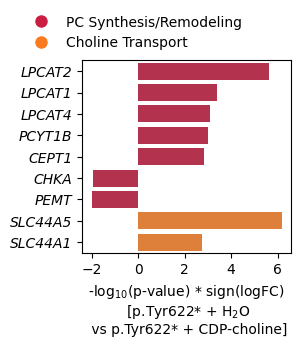

In [51]:
# Show some choline - related genes of interest 

# Define lists of genes in each category
phospholipid_genes = [
    'CHKA', 'CHKB', 'PCYT1A', 'PCYT1B', 
    'CHPT1', 'CEPT1', 'PEMT', 
    'LPCAT1', 'LPCAT2', 'LPCAT3', 'LPCAT4'
]

choline_transporter_genes = [
    'SLC44A2', 'SLC44A1', 'SLC44A3', 'SLC44A5'
]

fatty_acid_genes = [
    'SCD', 'SCD5', 'FADS1', 'FADS2', 'FADS3', 
    'ELOVL2', 'ELOVL5', 'ACSL'
]

# Create an empty dictionary to store the mapping
gene_to_category = {}

# Map each gene to its category
for gene in phospholipid_genes:
    gene_to_category[gene] = 'Phospholipid Synthesis/Remodeling'

for gene in choline_transporter_genes:
    gene_to_category[gene] = 'Choline Transport'

for gene in fatty_acid_genes:
    gene_to_category[gene] = 'Fatty Acid Metabolism'

genes = list(gene_to_category.keys())
y = data2.loc[np.array(genes)[[g in data2.index for g in genes]]]
y['category'] = y['genes'].map(gene_to_category)
y = y[y['adj.P.Val']<0.05]

y=y[y['category']!='Fatty Acid Metabolism']

plt.figure(figsize=(2.7, 2.5))
ax = sns.barplot(y='genes', x='score', data=y[['genes', 'score', 'category']].sort_values(['category', 'score'], ascending=[False, False]), width = .8, hue='category', 
            palette={'Choline Transport': '#F97A1F', 'Fatty Acid Metabolism': '#F97A1F', 'Phospholipid Synthesis/Remodeling': '#C91D42'}, dodge=False)

plt.ylabel('')
plt.title('')
plt.yticks(fontstyle='italic')


legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='#C91D42', markersize=10, label='PC Synthesis/Remodeling'),
    Line2D([0], [0], marker='o', markerfacecolor='#F97A1F', color='w',
           markersize=10, linestyle='None', label='Choline Transport')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(0.25, 1.3), loc='upper center', frameon=False)
plt.xlabel('-log$_{10}$(p-value) * sign(logFC) \n [p.Tyr622* + H$_2$O \n vs p.Tyr622* + CDP-choline]')

plt.savefig('../../paper/extended_plots/choline_synth_genes.png', dpi=300, bbox_inches='tight')
plt.show()



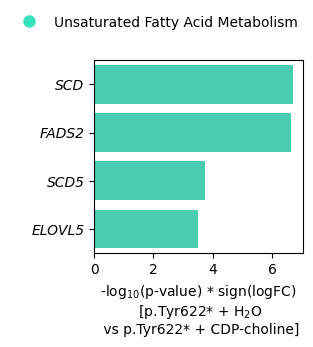

In [52]:
## Show desaturase genes

genes = list(gene_to_category.keys())
y = data2.loc[np.array(genes)[[g in data2.index for g in genes]]]
y['category'] = y['genes'].map(gene_to_category)
y = y[y['adj.P.Val']<0.05]

y=y[y['category']=='Fatty Acid Metabolism']

plt.figure(figsize=(2.7, 2.5))
ax = sns.barplot(y='genes', x='score', data=y[['genes', 'score', 'category']].sort_values(['category', 'score'], ascending=[False, False]), width = .8, hue='category', 
            palette={'Choline Transport': '#F97A1F', 'Fatty Acid Metabolism': '#36E2BD', 'Phospholipid Synthesis/Remodeling': '#C91D42'}, dodge=False)

plt.ylabel('')
plt.title('')
plt.yticks(fontstyle='italic')

legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='#36E2BD', markersize=10, label='Unsaturated Fatty Acid Metabolism'),
    
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(0.3, 1.3), loc='upper center', frameon=False)
plt.xlabel('-log$_{10}$(p-value) * sign(logFC) \n [p.Tyr622* + H$_2$O \n vs p.Tyr622* + CDP-choline]')

plt.savefig('../../paper/extended_plots/desaturase_genes.png', dpi=300, bbox_inches='tight')
plt.show()



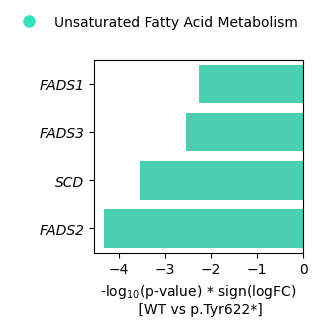

In [ ]:
# show desaturase genes 

genes = list(gene_to_category.keys())
y = data1.loc[np.array(genes)[[g in data1.index for g in genes]]]
y['category'] = y['genes'].map(gene_to_category)
y = y[y['adj.P.Val']<0.05]

y=y[y['category']=='Fatty Acid Metabolism']

plt.figure(figsize=(2.7, 2.5))
ax = sns.barplot(y='genes', x='score', data=y[['genes', 'score', 'category']].sort_values(['category', 'score'], ascending=[False, False]), width = .8, hue='category', 
            palette={'Choline Transport': '#F97A1F', 'Fatty Acid Metabolism': '#36E2BD', 'Phospholipid Synthesis/Remodeling': '#C91D42'}, dodge=False)

plt.ylabel('')
plt.title('')
plt.yticks(fontstyle='italic')


legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='#36E2BD', markersize=10, label='Unsaturated Fatty Acid Metabolism'),
    
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(0.3, 1.3), loc='upper center', frameon=False)
plt.xlabel('-log$_{10}$(p-value) * sign(logFC) \n [WT vs p.Tyr622*]')

plt.savefig('../../paper/extended_plots/desaturase_genes_e3_v_y622.png', dpi=300, bbox_inches='tight')
plt.show()



In [74]:
# MioCarta database
excel_file_path = '../../../../Downloads/Human.MitoCarta3.0.xls'
sheet_name = 'Sheet1'  # Replace with the name of the sheet you want to load
df = pd.read_excel(excel_file_path, sheet_name='A Human MitoCarta3.0')

# prepare the mito data
df['cat'] = [x.split(' |')[0].split('> ')[-1] if isinstance(x, str) else np.NaN for x in df['MitoCarta3.0_MitoPathways'].values]
dictionary = dict(zip(df['Symbol'], df['cat']))

# Subset our data
data1_mito = data1.loc[df['Symbol'][[x in set(data1.index) for x in df['Symbol']]]]
data2_mito = data2.loc[df['Symbol'][[x in set(data2.index) for x in df['Symbol']]]]
data3_mito = data3.loc[df['Symbol'][[x in set(data3.index) for x in df['Symbol']]]]

In [59]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb, to_hex
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from adjustText import adjust_text

def adjust_color(color, factor):
    """
    Adjust brightness of a color.
    factor > 1 makes the color lighter; factor < 1 makes it darker.
    """
    r, g, b = to_rgb(color)
    r = min(r * factor, 1)
    g = min(g * factor, 1)
    b = min(b * factor, 1)
    return to_hex((r, g, b))

def economist_distinct_palette(n_colors=25):
    # Define a few base colors reminiscent of The Economist style
    base_colors = [
        "#C8102E",  # bright red
        "#8C1515",  # deep red
        "#F6B600",  # gold/yellow
        "#555555",  # dark grey
        "#006E90",  # blueish
        "#008272",  # teal
        "#D4AF37",  # warm gold
        "#A7A9AC",  # light grey
        "#000000"   # black
    ]
    
    # Generate variations for each base color: original, lighter, and darker
    colors = []
    for base in base_colors:
        colors.append(base)
        colors.append(adjust_color(base, 1.3))  # lighter version
        colors.append(adjust_color(base, 0.7))  # darker version

    # Remove duplicates and select the first n_colors
    unique_colors = []
    for color in colors:
        if color not in unique_colors:
            unique_colors.append(color)
    return unique_colors[:n_colors]

# Generate the palette
palette = economist_distinct_palette(20)


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_46806/2089205833.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_mito[data1_mito['adj.P.Val']>0.05]['cat'] = 'other'
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_46806/2089205833.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

d

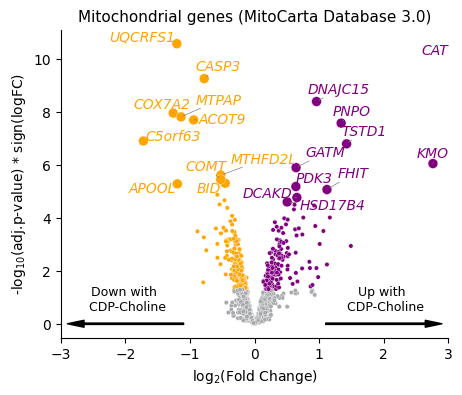

In [62]:
# prep data
data1_mito = data2.loc[df['Symbol'][[x in set(data2.index) for x in df['Symbol']]]]
#data1_mito['cat'] = data1_mito['genes'].map(dictionary)
#data1_mito['cat'][data1_mito['cat'].isna()] = 'other'
data1_mito[data1_mito['adj.P.Val']>0.05]['cat'] = 'other'

plt.figure(figsize=(5, 4))
bottom_genes = data1_mito.nsmallest(10, 'score').index
top_genes = data1_mito.nlargest(10, 'score').index
top_genes = np.concatenate([bottom_genes, top_genes])

data1_mito.loc[~data1_mito.index.isin(top_genes), 'cat'] = 'other'

# Your scatterplot
data1_mito['size'] = np.where(data1_mito.index.isin(top_genes), 50, 10)
data1_mito['cat'][(data1_mito['logFC']<0) & (data1_mito['adj.P.Val']<0.05)] = 'down'
data1_mito['cat'][(data1_mito['logFC']>0) & (data1_mito['adj.P.Val']<0.05)] = 'up'
data1_mito['cat'][data1_mito['adj.P.Val']>0.05] = 'other'
palette = {'down': 'orange', 'up': 'purple', 'other': '#A7A9AC'}
sns.scatterplot(data=data1_mito, x='logFC', y=-1*np.log10(data1_mito['adj.P.Val']), hue='cat', size='size', sizes=(10, 50), palette=palette)
# Label top genes
texts = []
for gene in top_genes:
    
    if data1_mito.loc[gene, 'adj.P.Val'] < 0.05:
        #print(gene)
        color = palette[data1_mito.loc[gene, 'cat']]
        txt = plt.text(data1_mito.loc[gene, 'logFC'],
                       -1 * np.log10(data1_mito.loc[gene, 'adj.P.Val']),
                       gene, fontsize=10, ha='right', va='bottom', style='italic', color=color)
        texts.append(txt)

# Adjust text positions to reduce overlap
plt.xlim(-3, 3)
#plt.ylim(0,6)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

sns.despine(top=True, right=True)
plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center left')

plt.annotate('', xy=(3,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(2, .5, 'Up with \n CDP-Choline', ha='center', fontsize=9)

plt.annotate('', xy=(-3,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-2, .5, 'Down with \n CDP-Choline', ha='center', fontsize=9)
plt.legend().remove()
plt.title('Mitochondrial genes (MitoCarta Database 3.0)', fontsize=11)

plt.savefig('../../paper/main_plots/choline_mito_degs.png', dpi=300, bbox_inches='tight')

plt.show()


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_46806/3395901095.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_mito[data1_mito['adj.P.Val']>0.05]['cat'] = 'other'
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_46806/3395901095.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

d

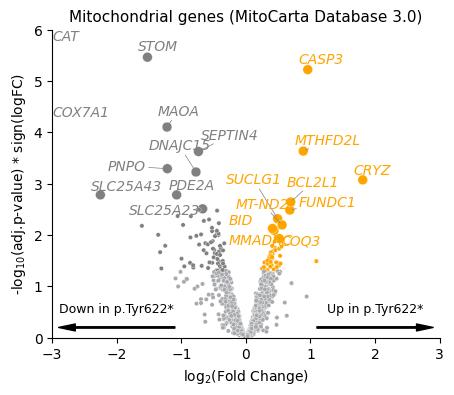

In [72]:
# prep data
data1_mito = data1.loc[df['Symbol'][[x in set(data1.index) for x in df['Symbol']]]]
#data1_mito['cat'] = data1_mito['genes'].map(dictionary)
#data1_mito['cat'][data1_mito['cat'].isna()] = 'other'
data1_mito[data1_mito['adj.P.Val']>0.05]['cat'] = 'other'

plt.figure(figsize=(5, 4))
bottom_genes = data1_mito.nsmallest(10, 'score').index
top_genes = data1_mito.nlargest(10, 'score').index
top_genes = np.concatenate([bottom_genes, top_genes])

data1_mito.loc[~data1_mito.index.isin(top_genes), 'cat'] = 'other'

# Your scatterplot
data1_mito['size'] = np.where(data1_mito.index.isin(top_genes), 50, 10)
data1_mito['cat'][(data1_mito['logFC']<0) & (data1_mito['adj.P.Val']<0.05)] = 'down'
data1_mito['cat'][(data1_mito['logFC']>0) & (data1_mito['adj.P.Val']<0.05)] = 'up'
data1_mito['cat'][data1_mito['adj.P.Val']>0.05] = 'other'
palette = {'down': 'grey', 'up': 'orange', 'other': '#A7A9AC'}
sns.scatterplot(data=data1_mito, x='logFC', y=-1*np.log10(data1_mito['adj.P.Val']), hue='cat', size='size', sizes=(10, 50), palette=palette)
# Label top genes
texts = []
for gene in top_genes:
    
    if data1_mito.loc[gene, 'adj.P.Val'] < 0.05:
        #print(gene)
        color = palette[data1_mito.loc[gene, 'cat']]
        txt = plt.text(data1_mito.loc[gene, 'logFC'],
                       -1 * np.log10(data1_mito.loc[gene, 'adj.P.Val']),
                       gene, fontsize=10, ha='right', va='bottom', style='italic', color=color)
        texts.append(txt)

# Adjust text positions to reduce overlap
plt.xlim(-3, 3)
plt.ylim(0,6)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

sns.despine(top=True, right=True)
plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center left')

plt.annotate('', xy=(3,0.2), xytext=(1, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(2, .5, 'Up in p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(-3,0.2), xytext=(-1, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-2, .5, 'Down in p.Tyr622*', ha='center', fontsize=9)
plt.legend().remove()
plt.title('Mitochondrial genes (MitoCarta Database 3.0)', fontsize=11)

plt.savefig('../../paper/main_plots/y622_mito_degs.png', dpi=300, bbox_inches='tight')

plt.show()


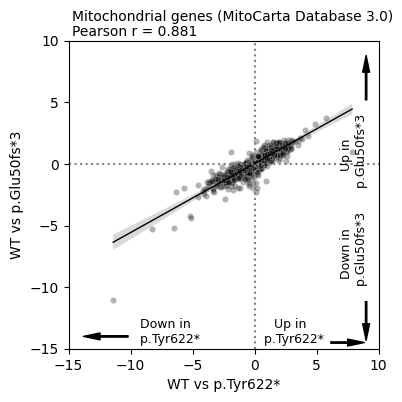

In [75]:
# Show mito correlations between the two lines 

data_merged = pd.merge(data1_mito, data3_mito, left_index=True, right_index=True)


plt.figure(figsize=(4, 4))

# Create a random subsample (e.g., 10% of the points)
sample_df = data_merged.sample(frac=1, random_state=42)

# Plot the regression line using the full dataset without scatter points
sns.regplot(x='score_x', y='score_y', data=data_merged, scatter=False, ci=95, color='black', line_kws={'linewidth': 1})

# Overlay scatter points from the subsample
sns.scatterplot(x='score_x', y='score_y', data=sample_df, color='black', alpha=0.3, s=20)

# Calculate Pearson correlation coefficient and p-value
r, p = stats.pearsonr(data_merged['score_x'], data_merged['score_y'])

# Add text annotation with the correlation coefficient
plt.text(0.01, 1.05, f'Pearson r = {r:.3f}',
         transform=plt.gca().transAxes, verticalalignment='top')

# Add horizontal and vertical dotted lines at zero
plt.axhline(y=0, color='grey', linestyle='dotted')
plt.axvline(x=0, color='grey', linestyle='dotted')

plt.xlabel('WT vs p.Tyr622*')
plt.ylabel('WT vs p.Glu50fs*3')
# Add arrow in lower right quadrant
plt.annotate('', xy=(9, 9), xytext=(9, 5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(3, -14.5, 'Up in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(-14, -14), xytext=(-10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-7, -14.5, 'Down in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(9, -14.5), xytext=(9, -11),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(8, -2, 'Up in \n p.Glu50fs*3', ha='center', fontsize=9, rotation=90)

plt.annotate('', xy=(9, -14.5), xytext=(6, -14.5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(8, -10, 'Down in \n p.Glu50fs*3', ha='center', fontsize=9, rotation=90)


plt.text(0.01, 1.1, 'Mitochondrial genes (MitoCarta Database 3.0)',
         transform=plt.gca().transAxes, verticalalignment='top')


plt.xlim(-15, 10)
plt.ylim(-15, 10)
plt.savefig('../../paper/extended_plots/rna_correlation_miocarta_both_lines.png', bbox_inches='tight')

plt.show()


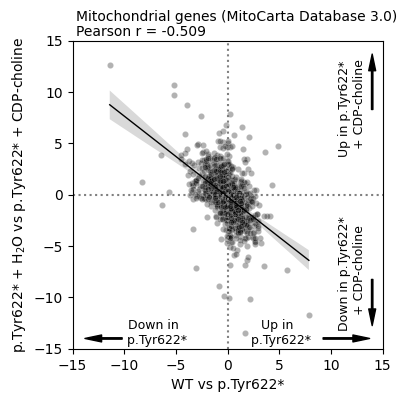

In [ ]:
# show mito correlations for CDP-choline and LoF

data_merged = pd.merge(data1_mito, data2_mito, left_index=True, right_index=True)


plt.figure(figsize=(4, 4))

# Create a random subsample (e.g., 10% of the points)
sample_df = data_merged.sample(frac=1, random_state=42)

# Plot the regression line using the full dataset without scatter points
sns.regplot(x='score_x', y='score_y', data=data_merged, scatter=False, ci=95, color='black', line_kws={'linewidth': 1})

# Overlay scatter points from the subsample
sns.scatterplot(x='score_x', y='score_y', data=sample_df, color='black', alpha=0.3, s=20)

# Calculate Pearson correlation coefficient and p-value
r, p = stats.pearsonr(data_merged['score_x'], data_merged['score_y'])

# Add text annotation with the correlation coefficient
plt.text(0.01, 1.05, f'Pearson r = {r:.3f}',
         transform=plt.gca().transAxes, verticalalignment='top')

# Add horizontal and vertical dotted lines at zero
plt.axhline(y=0, color='grey', linestyle='dotted')
plt.axvline(x=0, color='grey', linestyle='dotted')

plt.xlabel('WT vs p.Tyr622*')
plt.ylabel('p.Tyr622* + H$_2$O vs p.Tyr622* + CDP-choline')
# Add arrow in lower right quadrant
plt.annotate('', xy=(14, 14), xytext=(14, 8),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(5, -14.5, 'Up in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(-14, -14), xytext=(-10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-7, -14.5, 'Down in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(14, -13), xytext=(14, -8),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(12, 4, 'Up in p.Tyr622* \n + CDP-choline', ha='center', fontsize=9, rotation=90)

plt.annotate('', xy=(14, -14), xytext=(9, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(12, -13, 'Down in p.Tyr622*\n  + CDP-choline', ha='center', fontsize=9, rotation=90)


plt.text(0.01, 1.1, 'Mitochondrial genes (MitoCarta Database 3.0)',
         transform=plt.gca().transAxes, verticalalignment='top')


plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.savefig('../../paper/extended_plots/rna_correlation_miocarta_choline.png', bbox_inches='tight')

plt.show()


In [ ]:
import statsmodels.stats.multitest as smm
import gseapy as gp


In [78]:
# Load MioCarta Pathways
excel_file_path = '../../../../Downloads/Human.MitoCarta3.0.xls'
sheet_name = 'Sheet1'  # Replace with the name of the sheet you want to load
paths = pd.read_excel(excel_file_path, sheet_name='C MitoPathways')
paths = paths.dropna()
pathways = dict(zip(paths['MitoPathway'], [x.split(', ') for x in paths['Genes']]))


In [88]:
# characterise mito gene changes for Y622

genes_up = data1_mito[(data1_mito['adj.P.Val']<0.05) & (data1_mito['logFC']>0)]['genes'].values
genes_down = data1_mito[(data1_mito['adj.P.Val']<0.05) & (data1_mito['logFC']<0)]['genes'].values

enr = gp.enrichr(gene_list=list(genes_down),
                 gene_sets=pathways,
                 outdir='enrichr_results', cutoff=1, background=data1_mito['genes'].values)

temp = enr.results#.sort_values('P-value', ascending=True).head(10)
p_values = temp['P-value']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

x = temp.sort_values('P-value', ascending=True)#[:10]
x = x[x['P-value']<0.05]

x['direction'] = 'down'
x['score'] = np.log10(x['P-value'])
x['sig'] = x['FDR']<0.05


enr = gp.enrichr(gene_list=list(genes_up),
                 gene_sets=pathways,
                 outdir='enrichr_results', cutoff=1, background=data1_mito['genes'].values)

temp = enr.results#.sort_values('P-value', ascending=True).head(10)
p_values = temp['P-value']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

x2 = temp.sort_values('P-value', ascending=True)#[:10]
x2 = x2[x2['P-value']<0.05]

x2['direction'] = 'up'
x2['score'] = -np.log10(x2['P-value'])
x2['sig'] = x2['FDR']<0.05

both = pd.concat([x, x2])
both = both.sort_values('score', ascending=False)

both[['Term', 'score', 'P-value', 'FDR', 'Genes']]


,Term,score,P-value,FDR,Genes
1,Apoptosis,1.900274,0.012581,0.415774,BIK;CYCS;BCL2L1;BID;CASP3
43,OXPHOS,1.894438,0.012752,0.415774,COA4;COX14;NDUFA4;ATP5MG;MT-ND2;SDHAF2;CYCS;ND...
51,Protein import and sorting,1.755279,0.017568,0.415774,TOMM22;SAMM50;TIMM23;DNAJC19;TIMM8A;TIMM10
45,OXPHOS subunits,1.552584,0.028017,0.477391,NDUFA4;MT-ND2;ATP5MG;CYCS;NDUFA1;ATP5PB;COX6A1...
38,Mitochondrial dynamics and surveillance,1.473414,0.033619,0.477391,BIK;ATP5MG;CYCS;SAMM50;FUNDC2;BCL2L1;BID;CASP3...
2,Amino acid metabolism,-1.374004,0.042267,0.263353,GCAT;SFXN3;ABAT;DLST;AADAT;COMT;MCCC2;MAOA;ALD...
22,Detoxification,-1.395286,0.040245,0.263353,CYB5R3;EPHX2;TXNRD2;CYB5B;DHRS2;MAOA;CAT
23,EF hand proteins,-1.441227,0.036205,0.263353,RHOT2;SLC25A25;SLC25A23
37,Lipid metabolism,-1.441792,0.036158,0.263353,CPT1C;ACP6;IDI1;CYP27A1;CYB5R3;EPHX2;ACADL;SLC...
1,Amidoxime reducing complex,-1.576863,0.026493,0.238440,CYB5B;CYB5R3


In [89]:
both[['Term', 'score', 'P-value', 'FDR', 'Genes']].to_latex(index=False)

'\\begin{tabular}{lrrrl}\n\\toprule\nTerm & score & P-value & FDR & Genes \\\\\n\\midrule\nApoptosis & 1.900274 & 0.012581 & 0.415774 & BIK;CYCS;BCL2L1;BID;CASP3 \\\\\nOXPHOS & 1.894438 & 0.012752 & 0.415774 & COA4;COX14;NDUFA4;ATP5MG;MT-ND2;SDHAF2;CYCS;NDUFA1;ATP5PB;COX6A1;NDUFS4;ATP5MC3;TMEM126A;NDUFAF2 \\\\\nProtein import and sorting & 1.755279 & 0.017568 & 0.415774 & TOMM22;SAMM50;TIMM23;DNAJC19;TIMM8A;TIMM10 \\\\\nOXPHOS subunits & 1.552584 & 0.028017 & 0.477391 & NDUFA4;MT-ND2;ATP5MG;CYCS;NDUFA1;ATP5PB;COX6A1;NDUFS4;ATP5MC3 \\\\\nMitochondrial dynamics and surveillance & 1.473414 & 0.033619 & 0.477391 & BIK;ATP5MG;CYCS;SAMM50;FUNDC2;BCL2L1;BID;CASP3;FUNDC1 \\\\\nAmino acid metabolism & -1.374004 & 0.042267 & 0.263353 & GCAT;SFXN3;ABAT;DLST;AADAT;COMT;MCCC2;MAOA;ALDH5A1;SLC25A44 \\\\\nDetoxification & -1.395286 & 0.040245 & 0.263353 & CYB5R3;EPHX2;TXNRD2;CYB5B;DHRS2;MAOA;CAT \\\\\nEF hand proteins & -1.441227 & 0.036205 & 0.263353 & RHOT2;SLC25A25;SLC25A23 \\\\\nLipid metabolism 

In [ ]:
# characterise mito gene changes for choline

genes_up = data2_mito[(data2_mito['adj.P.Val']<0.05) & (data2_mito['logFC']>0)]['genes'].values
genes_down = data2_mito[(data2_mito['adj.P.Val']<0.05) & (data2_mito['logFC']<0)]['genes'].values

enr = gp.enrichr(gene_list=list(genes_down),
                 gene_sets=pathways,
                 outdir='enrichr_results', cutoff=1, background=data2_mito['genes'].values)

temp = enr.results#.sort_values('P-value', ascending=True).head(10)
p_values = temp['P-value']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

x = temp.sort_values('P-value', ascending=True)#[:10]
x = x[x['P-value']<0.05]
x['direction'] = 'down'
x['score'] = np.log10(x['P-value'])
x['sig'] = x['FDR']<0.05


enr = gp.enrichr(gene_list=list(genes_up),
                 gene_sets=pathways,
                 outdir='enrichr_results', cutoff=1, background=data2_mito['genes'].values)

temp = enr.results#.sort_values('P-value', ascending=True).head(10)
p_values = temp['P-value']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

x2 = temp.sort_values('P-value', ascending=True)#[:10]
x2 = x2[x2['P-value']<0.05]
x2['direction'] = 'up'
x2['score'] = -np.log10(x2['P-value'])
x2['sig'] = x2['FDR']<0.05

both = pd.concat([x, x2])
both = both.sort_values('score', ascending=False)

both[['Term', 'score', 'P-value', 'FDR', 'Genes']]




,Term,score,P-value,FDR,Genes
29,EF hand proteins,4.457699,3.485789e-05,0.003451,SLC25A12;EFHD1;SLC25A13;MICU3;SLC25A25;MICU2;S...
79,Small molecule transport,3.256577,5.538893e-04,0.027418,SLC25A12;SLC25A39;STARD7;SLC25A24;MICU2;ABCD2;...
12,Calcium homeostasis,3.079591,8.325479e-04,0.027474,SLC25A12;EFHD1;SLC25A13;MICU3;SLC25A24;LETM1;M...
50,Metabolism,2.846777,1.423060e-03,0.033450,ACP6;PNPO;ME3;MTFMT;ABAT;TST;SFXN5;FHIT;COQ2;S...
78,Signaling,2.772263,1.689416e-03,0.033450,SLC25A12;EFHD1;VDAC1;SLC25A13;MICU3;NLRX1;PDE2...
82,TCA-associated,2.563737,2.730630e-03,0.045055,ME3;SLC25A1;D2HGDH;PCK2;ME2;SFXN5;ACLY
35,Fusion,2.466941,3.412393e-03,0.048261,OPA1;MFN1;MIGA1;MIGA2;MFN2
14,Carbohydrate metabolism,1.960909,1.094186e-02,0.123756,SLC25A12;GLYCTK;OXCT1;ME3;FH;SLC25A13;DLST;SLC...
65,Organelle contact sites,1.856642,1.391100e-02,0.123756,FKBP8;MIGA2;MFN1;SPIRE1;VDAC1;MFN2
0,ABC transporters,1.852052,1.405880e-02,0.123756,ABCD2;ABCB10;ABCD1;ABCD3


In [87]:
both[['Term', 'score', 'P-value', 'FDR', 'Genes']].to_latex(index=False)

'\\begin{tabular}{lrrrl}\n\\toprule\nTerm & score & P-value & FDR & Genes \\\\\n\\midrule\nEF hand proteins & 4.457699 & 0.000035 & 0.003451 & SLC25A12;EFHD1;SLC25A13;MICU3;SLC25A25;MICU2;SLC25A24;SLC25A23 \\\\\nSmall molecule transport & 3.256577 & 0.000554 & 0.027418 & SLC25A12;SLC25A39;STARD7;SLC25A24;MICU2;ABCD2;ABCB10;SLC25A15;SFXN5;ABCD1;SLC25A13;SLC25A1;MPV17;MICU3;SLC25A29;SLC25A43;SFXN1;SLC25A25;SLC25A22;SLC25A23;VDAC1;MPV17L;ABCD3 \\\\\nCalcium homeostasis & 3.079591 & 0.000833 & 0.027474 & SLC25A12;EFHD1;SLC25A13;MICU3;SLC25A24;LETM1;MICU2;SLC25A23;SLC25A25;VDAC1 \\\\\nMetabolism & 2.846777 & 0.001423 & 0.033450 & ACP6;PNPO;ME3;MTFMT;ABAT;TST;SFXN5;FHIT;COQ2;SLC25A13;PDSS2;SPHK2;PPM1K;ALDH1B1;OAT;SLC25A29;SFXN1;SLC25A25;GLYCTK;GSR;ALDH3A2;GATM;CISD3;RFK;GCAT;STARD7;MCCC2;ABCB10;FH;ACADSB;SLC25A1;LACTB;D2HGDH;SERAC1;SOD2;NT5M;SPTLC2;AK4;ALDH5A1;MT-CO1;ACADS;ACLY;AGPAT5;ALDH7A1;OXCT1;SLC25A24;ECI1;TSTD1;IDI1;KMO;DLST;CHCHD7;AADAT;NNT;GPAT2;TK2;CS;CPT2;SLC25A23;ALDH9A1;OGDH;SLC

# Below is Scrap

In [729]:
# Load the specific sheet from the Excel file
excel_file_path = '../../../../Downloads/Human.MitoCarta3.0.xls'
sheet_name = 'Sheet1'  # Replace with the name of the sheet you want to load

# Read the specific sheet into a DataFrame
paths = pd.read_excel(excel_file_path, sheet_name='C MitoPathways')

# Display the first few rows of the DataFrame to verify the content
#df.head()


In [740]:
paths = paths.dropna()

In [770]:
pathways = dict(zip(paths['MitoPathway'], [x.split(', ') for x in paths['Genes']]))
all_genes = set(data1_mito['genes'].values)

In [772]:
# Subset pathways dictionary to only include genes in all_genes
subset_pathways = {k: [gene for gene in v if gene in all_genes] for k, v in pathways.items()}


In [804]:
genes_up = data2_mito[(data2_mito['adj.P.Val']<0.05) & (data2_mito['logFC']>0)]['genes'].values
genes_down = data2_mito[(data2_mito['adj.P.Val']<0.05) & (data2_mito['logFC']<0)]['genes'].values

In [758]:
pathways.keys()

dict_keys(['Mitochondrial central dogma', 'mtDNA maintenance', 'mtDNA replication', 'mtDNA nucleoid', 'mtDNA repair', 'mtDNA modifications', 'mtDNA stability and decay', 'mtRNA metabolism', 'Transcription', 'mtRNA granules', 'Polycistronic mtRNA processing', 'mt-tRNA modifications', 'mt-rRNA modifications', 'mt-mRNA modifications', 'mtRNA stability and decay', 'Translation', 'Mitochondrial ribosome', 'Mitochondrial ribosome assembly', 'Translation factors', 'mt-tRNA synthetases', 'fMet processing', 'Protein import, sorting and homeostasis', 'Protein import and sorting', 'TOM', 'SAM', 'MIA40', 'TIM22 carrier pathway', 'TIM23 presequence pathway', 'Import motor', 'OXA', 'Preprotein cleavage', 'Protein homeostasis', 'Proteases', 'Chaperones', 'OXPHOS', 'OXPHOS subunits', 'OXPHOS assembly factors', 'Complex I', 'CI subunits', 'CI assembly factors', 'Complex II', 'CII subunits', 'CII assembly factors', 'Complex III', 'CIII subunits', 'CIII assembly factors', 'Complex IV', 'CIV subunits', 'C

In [910]:
genes_up = data1_mito[(data1_mito['adj.P.Val']<0.05) & (data1_mito['logFC']>0)]['genes'].values
genes_down = data1_mito[(data1_mito['adj.P.Val']<0.05) & (data1_mito['logFC']<0)]['genes'].values

enr = gp.enrichr(gene_list=list(genes_down),
                 gene_sets=pathways,
                 outdir='enrichr_results', cutoff=1, background=data1_mito['genes'].values)

temp = enr.results#.sort_values('P-value', ascending=True).head(10)
p_values = temp['P-value']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals


In [912]:
temp[temp['Term']=='Fusion']

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,FDR
29,gs_ind_0,Fusion,1/8,0.441832,0.832288,2.655172,2.168812,MFN2,0.832288


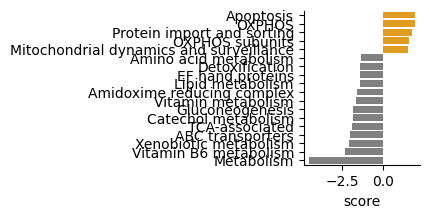

In [922]:
genes_up = data1_mito[(data1_mito['adj.P.Val']<0.05) & (data1_mito['logFC']>0)]['genes'].values
genes_down = data1_mito[(data1_mito['adj.P.Val']<0.05) & (data1_mito['logFC']<0)]['genes'].values

enr = gp.enrichr(gene_list=list(genes_down),
                 gene_sets=pathways,
                 outdir='enrichr_results', cutoff=1, background=data1_mito['genes'].values)

temp = enr.results#.sort_values('P-value', ascending=True).head(10)
p_values = temp['P-value']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

x = temp.sort_values('P-value', ascending=True)#[:10]
x = x[x['P-value']<0.05]

x['direction'] = 'down'
x['score'] = np.log10(x['P-value'])
x['sig'] = x['FDR']<0.05


enr = gp.enrichr(gene_list=list(genes_up),
                 gene_sets=pathways,
                 outdir='enrichr_results', cutoff=1, background=data1_mito['genes'].values)

temp = enr.results#.sort_values('P-value', ascending=True).head(10)
p_values = temp['P-value']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

x2 = temp.sort_values('P-value', ascending=True)#[:10]
x2 = x2[x2['P-value']<0.05]

x2['direction'] = 'up'
x2['score'] = -np.log10(x2['P-value'])
x2['sig'] = x2['FDR']<0.05

both = pd.concat([x, x2])
both = both.sort_values('score', ascending=False)

plt.figure(figsize=(1.5, 2))
ax = sns.barplot(data=both, x='score', y='Term', hue='direction', palette={'down': 'grey', 'up': 'orange'}, width=.8, dodge=False)

sns.despine(ax=ax, top=True, right=True)
plt.ylabel('')
ax.legend_.remove()
plt.show()

In [923]:
both[['Term', 'score', 'P-value', 'FDR', 'Genes']].to_latex(index=False)


'\\begin{tabular}{lrrrl}\n\\toprule\nTerm & score & P-value & FDR & Genes \\\\\n\\midrule\nApoptosis & 1.900274 & 0.012581 & 0.415774 & BID;CASP3;CYCS;BCL2L1;BIK \\\\\nOXPHOS & 1.894438 & 0.012752 & 0.415774 & NDUFA4;TMEM126A;ATP5MG;SDHAF2;NDUFA1;COX6A1;COX14;CYCS;COA4;NDUFS4;ATP5PB;ATP5MC3;NDUFAF2;MT-ND2 \\\\\nProtein import and sorting & 1.755279 & 0.017568 & 0.415774 & TIMM8A;TIMM10;DNAJC19;SAMM50;TIMM23;TOMM22 \\\\\nOXPHOS subunits & 1.552584 & 0.028017 & 0.477391 & NDUFA4;ATP5MG;NDUFA1;COX6A1;CYCS;NDUFS4;ATP5PB;ATP5MC3;MT-ND2 \\\\\nMitochondrial dynamics and surveillance & 1.473414 & 0.033619 & 0.477391 & BID;ATP5MG;SAMM50;CASP3;CYCS;BCL2L1;FUNDC1;BIK;FUNDC2 \\\\\nAmino acid metabolism & -1.374004 & 0.042267 & 0.263353 & DLST;COMT;SLC25A44;MAOA;ABAT;SFXN3;GCAT;ALDH5A1;MCCC2;AADAT \\\\\nDetoxification & -1.395286 & 0.040245 & 0.263353 & EPHX2;DHRS2;CYB5B;CAT;TXNRD2;MAOA;CYB5R3 \\\\\nEF hand proteins & -1.441227 & 0.036205 & 0.263353 & RHOT2;SLC25A23;SLC25A25 \\\\\nLipid metabolism 

In [896]:
both[['Term', 'score', 'P-value', 'FDR', 'Genes']].to_latex()

'\\begin{tabular}{llrrrl}\n\\toprule\n & Term & score & P-value & FDR & Genes \\\\\n\\midrule\n1 & Apoptosis & 1.900274 & 0.012581 & 0.415774 & BID;CASP3;CYCS;BCL2L1;BIK \\\\\n43 & OXPHOS & 1.894438 & 0.012752 & 0.415774 & NDUFA4;TMEM126A;ATP5MG;SDHAF2;NDUFA1;COX6A1;COX14;CYCS;COA4;NDUFS4;ATP5PB;ATP5MC3;NDUFAF2;MT-ND2 \\\\\n51 & Protein import and sorting & 1.755279 & 0.017568 & 0.415774 & TIMM8A;TIMM10;DNAJC19;SAMM50;TIMM23;TOMM22 \\\\\n45 & OXPHOS subunits & 1.552584 & 0.028017 & 0.477391 & NDUFA4;ATP5MG;NDUFA1;COX6A1;CYCS;NDUFS4;ATP5PB;ATP5MC3;MT-ND2 \\\\\n0 & ABC transporters & -2.026052 & 0.009418 & 0.165654 & ABCB6;ABCD2;ABCB8 \\\\\n74 & Xenobiotic metabolism & -2.103329 & 0.007883 & 0.165654 & EPHX2;DHRS2;CYB5B;MAOA;CYB5R3 \\\\\n72 & Vitamin B6 metabolism & -2.314663 & 0.004845 & 0.165654 & PNPO;PLPBP \\\\\n39 & Metabolism & -4.519649 & 0.000030 & 0.002448 & NMNAT3;DHRS4;CAT;GPAT2;DLAT;FECH;PNPO;SLC25A25;MCCC2;MMAB;COQ9;SLC25A1;PLPBP;ACLY;TXNRD2;ABAT;RFK;TK2;PC;IDI1;PCK2;EPHX2;D

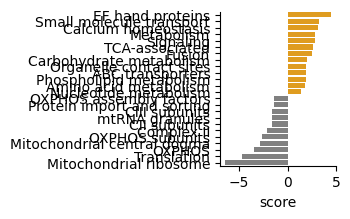

In [921]:
both[['Term', 'score', 'P-value', 'FDR', 'Genes']].to_latex(index=False)


'\\begin{tabular}{lrrrl}\n\\toprule\nTerm & score & P-value & FDR & Genes \\\\\n\\midrule\nEF hand proteins & 4.457699 & 0.000035 & 0.003451 & SLC25A12;SLC25A23;SLC25A25;EFHD1;MICU2;SLC25A13;MICU3;SLC25A24 \\\\\nSmall molecule transport & 3.256577 & 0.000554 & 0.027418 & ABCB10;SLC25A25;MPV17L;ABCD3;ABCD1;SLC25A12;SLC25A1;SLC25A13;MICU3;SFXN1;SLC25A29;SLC25A39;SLC25A43;MICU2;SFXN5;STARD7;SLC25A24;ABCD2;SLC25A15;SLC25A22;SLC25A23;VDAC1;MPV17 \\\\\nCalcium homeostasis & 3.079591 & 0.000833 & 0.027474 & SLC25A12;SLC25A23;SLC25A25;EFHD1;VDAC1;LETM1;SLC25A13;MICU2;MICU3;SLC25A24 \\\\\nMetabolism & 2.846777 & 0.001423 & 0.033450 & ABCB10;NT5DC2;ACSL6;ME3;CS;SLC25A12;PDSS2;HSD17B4;ACLY;TK2;ALDH3A2;IDI1;NADK2;ACADS;CPT2;STARD7;AADAT;ACAD10;AK3;NNT;SOD2;CHCHD7;SLC25A23;OGDH;NMNAT3;MT-CO1;GLS;GPAT2;SLC25A25;OAT;D2HGDH;SLC25A1;ABAT;RFK;SFXN1;ALDH1B1;OXCT1;TST;HIBCH;FHIT;FH;GLYCTK;LACTB;PNPO;SERAC1;ME2;GSR;AGPAT5;PCK2;SLC25A29;EPHX2;GLDC;SFXN5;PDK3;ALDH5A1;SPHK2;SLC25A24;TSTD1;MTFMT;ACP6;NT5M;ALDH

In [813]:
temp.sort_values('P-value', ascending=True).iloc[0]['Genes']

'NMNAT3;DHRS4;CAT;GPAT2;DLAT;FECH;PNPO;SLC25A25;MCCC2;MMAB;COQ9;SLC25A1;PLPBP;ACLY;TXNRD2;ABAT;RFK;TK2;PC;IDI1;PCK2;EPHX2;DHRS2;ACADVL;IDH2;CPT1C;CROT;ALDH5A1;AADAT;ACAD10;TSTD1;CYB5B;DLST;SLC25A44;ABCB6;GATM;SLC25A23;MAOA;ACADL;SFXN3;ACP6;GCAT;COMT;CYP27A1;CYB5R3'

In [907]:
data2.loc['OPA1']

genes            OPA1
logFC        0.364388
AveExpr      6.141216
t            3.879033
P.Value      0.001112
adj.P.Val    0.005926
B           -2.326228
score        2.953759
Name: OPA1, dtype: object

In [905]:
both[both['Adjusted P-value']<0.05]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,FDR,direction,score,sig
29,gs_ind_0,EF hand proteins,8/11,3.485789e-05,0.003451,13.586034,139.450188,SLC25A12;SLC25A23;SLC25A25;EFHD1;MICU2;SLC25A1...,0.003451,up,4.457699,True
79,gs_ind_0,Small molecule transport,23/75,5.538893e-04,0.027418,2.614538,19.605233,ABCB10;SLC25A25;MPV17L;ABCD3;ABCD1;SLC25A12;SL...,0.027418,up,3.256577,True
12,gs_ind_0,Calcium homeostasis,10/22,8.325479e-04,0.027474,4.711068,33.406276,SLC25A12;SLC25A23;SLC25A25;EFHD1;VDAC1;LETM1;S...,0.027474,up,3.079591,True
50,gs_ind_0,Metabolism,81/402,1.423060e-03,0.033450,1.692525,11.094408,ABCB10;NT5DC2;ACSL6;ME3;CS;SLC25A12;PDSS2;HSD1...,0.033450,up,2.846777,True
78,gs_ind_0,Signaling,15/44,1.689416e-03,0.033450,2.985602,19.058207,NLRX1;SLC25A12;PPTC7;SLC25A23;SLC25A25;EFHD1;V...,0.033450,up,2.772263,True
82,gs_ind_0,TCA-associated,7/14,2.730630e-03,0.045055,5.533333,32.664500,SLC25A1;ACLY;ME2;SFXN5;ME3;D2HGDH;PCK2,0.045055,up,2.563737,True
35,gs_ind_0,Fusion,5/8,3.412393e-03,0.048261,8.625616,48.996444,OPA1;MIGA2;MFN2;MIGA1;MFN1,0.048261,up,2.466941,True
52,gs_ind_0,Mitochondrial central dogma,59/226,1.364626e-03,0.036163,1.755452,11.580496,MRPL4;MRPL18;COA3;MTRES1;MRPL46;MTIF3;MRPS23;M...,0.036163,down,-2.864986,True
61,gs_ind_0,OXPHOS,47/162,3.796325e-04,0.013414,2.012263,15.849202,UQCR10;FOXRED1;TIMMDC1;ATP5MG;COA3;SDHB;ATP5PB...,0.013414,down,-3.420637,True
87,gs_ind_0,Translation,48/151,2.218251e-05,0.001176,2.346151,25.141835,MRPL4;MRPL18;COA3;MTRES1;MRPL46;MTIF3;MRPS23;M...,0.001176,down,-4.653989,True


In [782]:
enr = gp.enrichr(gene_list=list(genes_down),
                 gene_sets=subset_pathways,
                 outdir='enrichr_results', cutoff=1)

temp = enr.results#.sort_values('P-value', ascending=True).head(10)
p_values = temp['P-value']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

temp.sort_values('FDR', ascending=True).head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,FDR
55,gs_ind_0,Mitochondrial ribosome,34/81,7.081188e-07,0.000075,3.481972,49.307006,MRPL4;MRPL18;MRPL46;MRPS23;MRPL37;MRPL45;MRPL3...,0.000075
87,gs_ind_0,Translation,48/151,4.308153e-05,0.002283,2.284635,22.966100,MRPL4;MRPL18;COA3;MTRES1;MRPL46;MTIF3;MRPS23;M...,0.002283
61,gs_ind_0,OXPHOS,47/162,6.860322e-04,0.024240,1.954585,14.238341,UQCR10;FOXRED1;TIMMDC1;ATP5MG;COA3;SDHB;ATP5PB...,0.024240
52,gs_ind_0,Mitochondrial central dogma,59/226,2.578579e-03,0.068332,1.702527,10.147942,MRPL4;MRPL18;COA3;MTRES1;MRPL46;MTIF3;MRPS23;M...,0.068332
63,gs_ind_0,OXPHOS subunits,29/95,3.917040e-03,0.083041,2.004086,11.107483,UQCR10;ATP5MG;SDHB;ATP5PB;UQCRH;NDUFA10;COX5B;...,0.083041
25,gs_ind_0,Complex II,5/8,8.662752e-03,0.153042,6.701552,31.823813,SDHAF2;SDHAF3;SDHC;SDHB;SDHD,0.153042
103,gs_ind_0,mtRNA granules,10/28,2.947891e-02,0.347196,2.441028,8.602380,MRPL47;ERAL1;MTPAP;ALKBH1;PTCD2;MRPS7;TFB1M;TR...,0.347196
7,gs_ind_0,CII subunits,3/4,2.442402e-02,0.347196,9.866850,36.627607,SDHD;SDHC;SDHB,0.347196
9,gs_ind_0,CIII subunits,5/10,2.784126e-02,0.347196,4.253482,15.232723,UQCR10;CYC1;UQCRH;UQCRC1;UQCRFS1,0.347196
62,gs_ind_0,OXPHOS assembly factors,19/68,4.803946e-02,0.462926,1.712625,5.199071,FOXRED1;TIMMDC1;COA3;COA6;COX7A2L;SDHAF3;FMC1;...,0.462926


In [745]:

pre_res = gp.prerank(
    rnk=rnk,
    gene_sets=pathways,
    outdir="gseapy_out",
    permutation_num=1000,
    seed=6,
    min_size=5
)

NameError: name 'gseapy' is not defined

In [728]:
df

,HumanGeneID,MouseOrthologGeneID,Symbol,Synonyms,Description,MitoCarta3.0_List,MitoCarta3.0_Evidence,MitoCarta3.0_SubMitoLocalization,MitoCarta3.0_MitoPathways,TrainingDataset,...,heart_total_peak_intensity_log10,skeletalmuscle_total_peak_intensity_log10,adipose_total_peak_intensity_log10,smallintestine_total_peak_intensity_log10,largeintestine_total_peak_intensity_log10,stomach_total_peak_intensity_log10,placenta_total_peak_intensity_log10,testis_total_peak_intensity_log10,HPA_Main_Location_2020 (Reliability),cat
0,1537,66445.0,CYC1,MC3DN6|UQCR4,cytochrome c1,MitoCarta3.0,"literature, APEX_IMS, APEX_matrix, targetP sig...",MIM,OXPHOS > Complex III > CIII subunits | Metabol...,Tmito,...,10.4,9.8,10.1,10.2,10.2,10.0,10.0,9.8,Mitochondria (Supported),CIII subunits
1,6390,67680.0,SDHB,CWS2|IP|PGL4|SDH|SDH1|SDH2|SDHIP,succinate dehydrogenase complex iron sulfur su...,MitoCarta3.0,"literature, APEX_matrix, targetP signal+, yeas...",MIM,OXPHOS > Complex II > CII subunits | Metabolis...,Tmito,...,10.3,9.2,10.1,10.3,9.9,9.9,10.1,9.9,Mitochondria (Supported),CII subunits
2,10229,12850.0,COQ7,CAT5|CLK-1|CLK1|COQ10D8,"coenzyme Q7, hydroxylase",MitoCarta3.0,"literature, targetP signal+, yeast mito homolo...",MIM,Metabolism > Metals and cofactors > Coenzyme Q...,Tmito,...,8.6,8.7,8.8,8.6,9.0,8.7,8.3,8.3,Plasma membrane (Approved),Coenzyme Q metabolism
3,6389,66945.0,SDHA,CMD1GG|FP|PGL5|SDH1|SDH2|SDHF,succinate dehydrogenase complex flavoprotein s...,MitoCarta3.0,"literature, APEX_matrix, targetP signal+, yeas...",MIM,OXPHOS > Complex II > CII subunits | Metabolis...,Tmito,...,10.7,10.6,10.6,10.7,10.6,10.5,10.4,10.4,Mitochondria (Supported),CII subunits
4,7384,22273.0,UQCRC1,D3S3191|QCR1|UQCR1,ubiquinol-cytochrome c reductase core protein 1,MitoCarta3.0,"literature, APEX_matrix, targetP signal+, yeas...",MIM,"Protein import, sorting and homeostasis > Prot...",Tmito,...,10.8,10.3,10.1,10.6,10.2,10.3,10.2,9.9,Mitochondria (Supported),Preprotein cleavage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,339983,269642.0,NAT8L,CML3|NACED|NAT8-LIKE,N-acetyltransferase 8 like,MitoCarta3.0,literature,Membrane,Metabolism > Amino acid metabolism > Glutamate...,Tpossible_mito,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mitochondria (Approved),Glutamate metabolism
1132,401250,NaN,MCCD1,-,mitochondrial coiled-coil domain 1,MitoCarta3.0,manual,unknown,0,Tpossible_mito,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1133,101928527,66364.0,PIGBOS1,HP06981,PIGB opposite strand 1,MitoCarta3.0,literature,MOM,Mitochondrial dynamics and surveillance > Orga...,NA - newly added to NCBI Entrez Gene,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Organelle contact sites
1134,109703458,109729085.0,HTD2,-,hydroxyacyl-thioester dehydratase type 2,MitoCarta3.0,literature,Matrix,Metabolism > Lipid metabolism > Type II fatty ...,NA - newly added to NCBI Entrez Gene,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mitochondria (Supported),Type II fatty acid synthesis


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_61885/955358491.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_mito[data1_mito['adj.P.Val']>0.05]['cat'] = 'other'
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_61885/955358491.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_mito.loc[~data1_mito.index.isin(top_genes), 'cat'] = 'other'
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_61885/955358491.py:15: SettingWithCopyWarning: 
A value is trying to be s

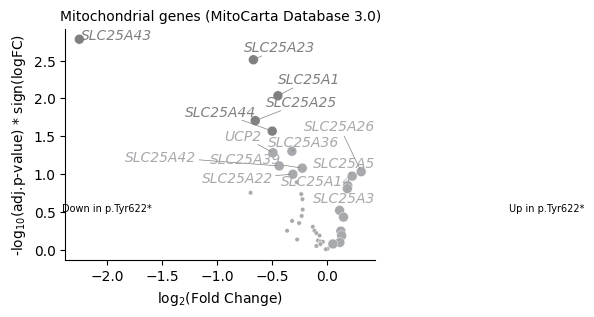

In [683]:
# prep data
data1_mito = data1[data1['genes'].str.startswith('SLC25A') | data1['genes'].str.startswith('UCP')]
#data1_mito['cat'] = data1_mito['genes'].map(dictionary)
#data1_mito['cat'][data1_mito['cat'].isna()] = 'other'
data1_mito[data1_mito['adj.P.Val']>0.05]['cat'] = 'other'

plt.figure(figsize=(4, 3))
bottom_genes = data1_mito.nsmallest(10, 'score').index
top_genes = data1_mito.nlargest(10, 'score').index
top_genes = np.concatenate([bottom_genes, top_genes])

data1_mito.loc[~data1_mito.index.isin(top_genes), 'cat'] = 'other'

# Your scatterplot
data1_mito['size'] = np.where(data1_mito.index.isin(top_genes), 50, 10)
data1_mito['cat'][(data1_mito['logFC']<0) & (data1_mito['adj.P.Val']<0.05)] = 'down'
data1_mito['cat'][(data1_mito['logFC']>0) & (data1_mito['adj.P.Val']<0.05)] = 'up'
data1_mito['cat'][data1_mito['adj.P.Val']>0.05] = 'other'
palette = {'down': 'grey', 'up': 'orange', 'other': '#A7A9AC'}
sns.scatterplot(data=data1_mito, x='logFC', y=-1*np.log10(data1_mito['adj.P.Val']), hue='cat', size='size', sizes=(10, 50), palette=palette)
# Label top genes
texts = []
for gene in top_genes:
    
    if data1_mito.loc[gene, 'P.Value'] < 0.05:
        #print(gene)
        color = palette[data1_mito.loc[gene, 'cat']]
        txt = plt.text(data1_mito.loc[gene, 'logFC'],
                       -1 * np.log10(data1_mito.loc[gene, 'adj.P.Val']),
                       gene, fontsize=10, ha='right', va='bottom', style='italic', color=color)
        texts.append(txt)

# Adjust text positions to reduce overlap
#plt.xlim(-3, 3)
#plt.ylim(0,6)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

sns.despine(top=True, right=True)
plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center left')

plt.annotate('', xy=(3,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(2, .5, 'Up in p.Tyr622*', ha='center', fontsize=7)

plt.annotate('', xy=(-3,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-2, .5, 'Down in p.Tyr622*', ha='center', fontsize=7)
plt.legend().remove()
plt.title('Mitochondrial genes (MitoCarta Database 3.0)', fontsize=10)

#plt.savefig('../../paper/main_plots/y622_mito_degs.png', dpi=300, bbox_inches='tight')

plt.show()


In [675]:
data1.loc[data1['genes'].isin(genes)]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,score
genes,,,,,,,,
SLC25A5,SLC25A5,0.228895,7.596151,2.566022,0.024070,0.106907,-4.942853,1.618527
SLC25A14,SLC25A14,0.188000,7.071055,2.306766,0.038909,0.142502,-5.366614,1.409945
SLC25A4,SLC25A4,0.114127,9.334606,1.603885,0.133694,0.303505,-6.654607,0.873889
SLC25A27,SLC25A27,-0.129514,5.957794,-1.068382,0.305547,0.500192,-7.091216,-0.514923


In [671]:
genes = [
    "SLC25A4",  # ANT1
    "SLC25A5",  # ANT2
    "SLC25A6",  # ANT3
    "SLC25A8",  # UCP2
    "SLC25A9",  # UCP3
    "SLC25A27", # UCP4
    "SLC25A14"  # UCP5
]

In [666]:
data1_mito[data1_mito['cat'] == 'down']['genes']

genes
SLC25A43    SLC25A43
SLC25A23    SLC25A23
SLC25A1      SLC25A1
SLC25A25    SLC25A25
SLC25A44    SLC25A44
Name: genes, dtype: object

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_61885/1972965696.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3_mito[data3_mito['adj.P.Val']>0.05]['cat'] = 'other'
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_61885/1972965696.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

d

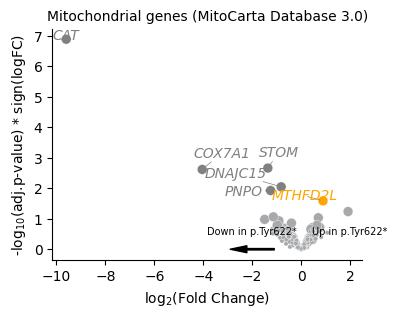

In [477]:
# prep data
data3_mito = data3.loc[df['Symbol'][[x in set(data3.index) for x in df['Symbol']]]]
#data1_mito['cat'] = data1_mito['genes'].map(dictionary)
#data1_mito['cat'][data1_mito['cat'].isna()] = 'other'
data3_mito[data3_mito['adj.P.Val']>0.05]['cat'] = 'other'

plt.figure(figsize=(4, 3))
bottom_genes = data3_mito.nsmallest(10, 'score').index
top_genes = data3_mito.nlargest(10, 'score').index
top_genes = np.concatenate([bottom_genes, top_genes])

data3_mito.loc[~data3_mito.index.isin(top_genes), 'cat'] = 'other'

# Your scatterplot
data3_mito['size'] = np.where(data1_mito.index.isin(top_genes), 50, 10)
data3_mito['cat'][(data3_mito['logFC']<0) & (data3_mito['adj.P.Val']<0.05)] = 'down'
data3_mito['cat'][(data3_mito['logFC']>0) & (data3_mito['adj.P.Val']<0.05)] = 'up'
data3_mito['cat'][data3_mito['adj.P.Val']>0.05] = 'other'
palette = {'down': 'grey', 'up': 'orange', 'other': '#A7A9AC'}
sns.scatterplot(data=data1_mito, x='logFC', y=-1*np.log10(data1_mito['adj.P.Val']), hue='cat', size='size', sizes=(10, 50), palette=palette)
# Label top genes
texts = []
for gene in top_genes:
    
    if data3_mito.loc[gene, 'adj.P.Val'] < 0.05:
        #print(gene)
        color = palette[data3_mito.loc[gene, 'cat']]
        txt = plt.text(data3_mito.loc[gene, 'logFC'],
                       -1 * np.log10(data3_mito.loc[gene, 'adj.P.Val']),
                       gene, fontsize=10, ha='right', va='bottom', style='italic', color=color)
        texts.append(txt)

# Adjust text positions to reduce overlap
#plt.xlim(-3, 3)
#plt.ylim(0,6)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

sns.despine(top=True, right=True)
plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center left')

plt.annotate('', xy=(3,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(2, .5, 'Up in p.Tyr622*', ha='center', fontsize=7)

plt.annotate('', xy=(-3,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-2, .5, 'Down in p.Tyr622*', ha='center', fontsize=7)
plt.legend().remove()
plt.title('Mitochondrial genes (MitoCarta Database 3.0)', fontsize=10)

plt.savefig('../../paper/main_plots/glu_mito_degs.png', dpi=300, bbox_inches='tight')

plt.show()


In [486]:
data1_mito.index = np.arange(len(data1_mito))
data3_mito.index = np.arange(len(data3_mito))

In [490]:
data3_mito

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,score,cat,size
0,CYC1,0.038580,8.298457,0.239417,0.815018,0.922226,-7.370177,0.088833,other,10
1,SDHB,0.149029,7.292928,1.081804,0.301618,0.617394,-6.748176,0.520542,other,10
2,COQ7,0.067097,5.328680,0.475868,0.643127,0.834369,-7.101642,0.191703,other,10
3,SDHA,0.090554,5.534595,0.523918,0.610336,0.818459,-7.093837,0.214431,other,10
4,UQCRC1,-0.038445,9.231629,-0.257892,0.801071,0.914934,-7.405510,-0.096329,other,10
...,...,...,...,...,...,...,...,...,...,...
1037,ARMCX6,0.260853,5.067642,1.638446,0.128519,0.467775,-5.887019,0.891034,other,10
1038,METTL4,-0.131549,3.181515,-0.475300,0.643520,0.834416,-6.885378,-0.191438,other,10
1039,SPHKAP,-0.131210,3.753122,-0.376426,0.713489,0.872345,-6.999898,-0.146613,other,10
1040,NAT8L,-0.214086,2.277952,-0.989431,0.342920,0.646936,-6.365846,-0.464807,other,10


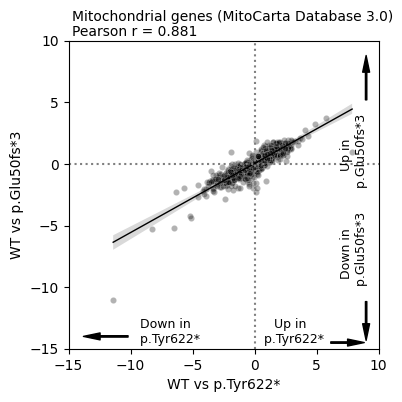

In [588]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import stack_data  # Adjust this to your module's data-loading function

data_merged = pd.merge(data1_mito, data3_mito, left_index=True, right_index=True)


plt.figure(figsize=(4, 4))

# Create a random subsample (e.g., 10% of the points)
sample_df = data_merged.sample(frac=1, random_state=42)

# Plot the regression line using the full dataset without scatter points
sns.regplot(x='score_x', y='score_y', data=data_merged, scatter=False, ci=95, color='black', line_kws={'linewidth': 1})

# Overlay scatter points from the subsample
sns.scatterplot(x='score_x', y='score_y', data=sample_df, color='black', alpha=0.3, s=20)

# Calculate Pearson correlation coefficient and p-value
r, p = stats.pearsonr(data_merged['score_x'], data_merged['score_y'])

# Add text annotation with the correlation coefficient
plt.text(0.01, 1.05, f'Pearson r = {r:.3f}',
         transform=plt.gca().transAxes, verticalalignment='top')

# Add horizontal and vertical dotted lines at zero
plt.axhline(y=0, color='grey', linestyle='dotted')
plt.axvline(x=0, color='grey', linestyle='dotted')

plt.xlabel('WT vs p.Tyr622*')
plt.ylabel('WT vs p.Glu50fs*3')
# Add arrow in lower right quadrant
plt.annotate('', xy=(9, 9), xytext=(9, 5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(3, -14.5, 'Up in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(-14, -14), xytext=(-10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-7, -14.5, 'Down in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(9, -14.5), xytext=(9, -11),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(8, -2, 'Up in \n p.Glu50fs*3', ha='center', fontsize=9, rotation=90)

plt.annotate('', xy=(9, -14.5), xytext=(6, -14.5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(8, -10, 'Down in \n p.Glu50fs*3', ha='center', fontsize=9, rotation=90)


plt.text(0.01, 1.1, 'Mitochondrial genes (MitoCarta Database 3.0)',
         transform=plt.gca().transAxes, verticalalignment='top')


plt.xlim(-15, 10)
plt.ylim(-15, 10)
plt.savefig('../../paper/extended_plots/rna_correlation_miocarta_both_lines.png', bbox_inches='tight')

plt.show()


In [591]:
data2_mito.index = np.arange(len(data2_mito))

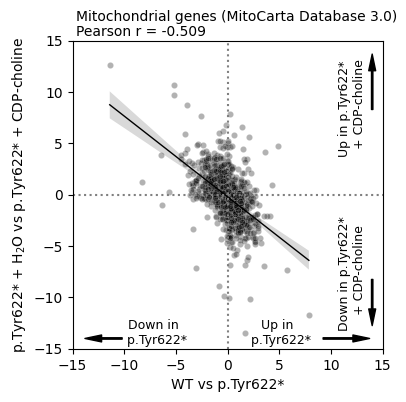

In [640]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import stack_data  # Adjust this to your module's data-loading function

data_merged = pd.merge(data1_mito, data2_mito, left_index=True, right_index=True)


plt.figure(figsize=(4, 4))

# Create a random subsample (e.g., 10% of the points)
sample_df = data_merged.sample(frac=1, random_state=42)

# Plot the regression line using the full dataset without scatter points
sns.regplot(x='score_x', y='score_y', data=data_merged, scatter=False, ci=95, color='black', line_kws={'linewidth': 1})

# Overlay scatter points from the subsample
sns.scatterplot(x='score_x', y='score_y', data=sample_df, color='black', alpha=0.3, s=20)

# Calculate Pearson correlation coefficient and p-value
r, p = stats.pearsonr(data_merged['score_x'], data_merged['score_y'])

# Add text annotation with the correlation coefficient
plt.text(0.01, 1.05, f'Pearson r = {r:.3f}',
         transform=plt.gca().transAxes, verticalalignment='top')

# Add horizontal and vertical dotted lines at zero
plt.axhline(y=0, color='grey', linestyle='dotted')
plt.axvline(x=0, color='grey', linestyle='dotted')

plt.xlabel('WT vs p.Tyr622*')
plt.ylabel('p.Tyr622* + H$_2$O vs p.Tyr622* + CDP-choline')
# Add arrow in lower right quadrant
plt.annotate('', xy=(14, 14), xytext=(14, 8),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(5, -14.5, 'Up in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(-14, -14), xytext=(-10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-7, -14.5, 'Down in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(14, -13), xytext=(14, -8),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(12, 4, 'Up in p.Tyr622* \n + CDP-choline', ha='center', fontsize=9, rotation=90)

plt.annotate('', xy=(14, -14), xytext=(9, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(12, -13, 'Down in p.Tyr622*\n  + CDP-choline', ha='center', fontsize=9, rotation=90)


plt.text(0.01, 1.1, 'Mitochondrial genes (MitoCarta Database 3.0)',
         transform=plt.gca().transAxes, verticalalignment='top')


plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.savefig('../../paper/extended_plots/rna_correlation_miocarta_choline.png', bbox_inches='tight')

plt.show()


## Below is Scrap

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_61885/2088305225.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_mito[data1_mito['adj.P.Val']>0.05]['cat'] = 'other'
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_61885/2088305225.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

d

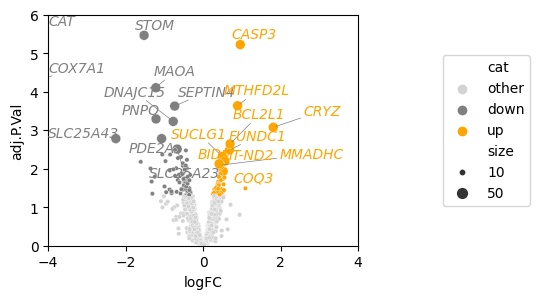

In [407]:
# prep data
data1_mito = data1.loc[df['Symbol'][[x in set(data1.index) for x in df['Symbol']]]]
#data1_mito['cat'] = data1_mito['genes'].map(dictionary)
#data1_mito['cat'][data1_mito['cat'].isna()] = 'other'
data1_mito[data1_mito['adj.P.Val']>0.05]['cat'] = 'other'

plt.figure(figsize=(4, 3))
bottom_genes = data1_mito.nsmallest(10, 'score').index
top_genes = data1_mito.nlargest(10, 'score').index
top_genes = np.concatenate([bottom_genes, top_genes])

data1_mito.loc[~data1_mito.index.isin(top_genes), 'cat'] = 'other'

# Your scatterplot
data1_mito['size'] = np.where(data1_mito.index.isin(top_genes), 50, 10)
data1_mito['cat'][(data1_mito['logFC']<0) & (data1_mito['adj.P.Val']<0.05)] = 'down'
data1_mito['cat'][(data1_mito['logFC']>0) & (data1_mito['adj.P.Val']<0.05)] = 'up'
data1_mito['cat'][data1_mito['adj.P.Val']>0.05] = 'other'
palette = {'down': 'gray', 'up': 'orange', 'other': 'lightgrey'}
sns.scatterplot(data=data1_mito, x='logFC', y=-1*np.log10(data1_mito['adj.P.Val']), hue='cat', size='size', sizes=(10, 50), palette=palette)
# Label top genes
texts = []
for gene in top_genes:
    
    if data1_mito.loc[gene, 'adj.P.Val'] < 0.05:
        #print(gene)
        color = palette[data1_mito.loc[gene, 'cat']]
        txt = plt.text(data1_mito.loc[gene, 'logFC'],
                       -1 * np.log10(data1_mito.loc[gene, 'adj.P.Val']),
                       gene, fontsize=10, ha='right', va='bottom', style='italic', color=color)
        texts.append(txt)

# Adjust text positions to reduce overlap
plt.xlim(-4, 4)
plt.ylim(0,6)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center left')
plt.show()


In [657]:
data1_mito[data1_mito['genes'] == 'UCP2']

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,score,cat,size
815,UCP2,-0.491852,2.568785,-3.213421,0.0071,0.052417,-3.169911,-2.148715,other,10


In [658]:
data1.loc[['UCP2']]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,score
genes,,,,,,,,
UCP2,UCP2,-0.491852,2.568785,-3.213421,0.0071,0.052417,-3.169911,-2.148715


In [410]:
bottom_genes = data1_mito.nsmallest(10, 'score').index
top_genes = data1_mito.nlargest(10, 'score').index
bottom_genes

Index(['UQCRFS1', 'CASP3', 'COX7A2', 'MTPAP', 'ACOT9', 'C5orf63', 'MTHFD2L',
       'COMT', 'BID', 'APOOL'],
      dtype='object', name='genes')

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_61885/120320246.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data1_mito['cat'][data1_mito['cat'].isna()] = 'other'
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_6

CAT
STOM
COX7A1
MAOA
SEPTIN4
PNPO
DNAJC15
SLC25A43
PDE2A
SLC25A23
SPATA20
IDI1
TSTD1
ACP6
ACAD9
EPHX2
CYB5R3
CYP27A1
GPAT2
TRMT2B


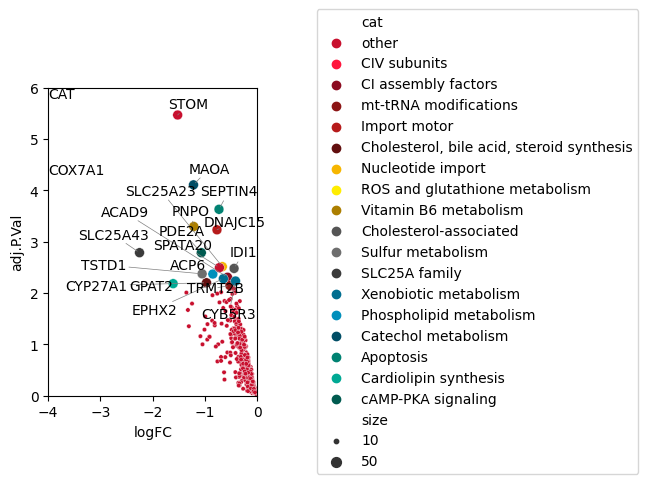

In [376]:
# prep data
data1_mito = data1.loc[df['Symbol'][[x in set(data1.index) for x in df['Symbol']]]]
data1_mito['cat'] = data1_mito['genes'].map(dictionary)
data1_mito['cat'][data1_mito['cat'].isna()] = 'other'
data1_mito[data1_mito['adj.P.Val']>0.05]['cat'] = 'other'

plt.figure(figsize=(2.7, 4))
top_genes = data1_mito.nsmallest(20, 'score').index
data1_mito.loc[~data1_mito.index.isin(top_genes), 'cat'] = 'other'

# Your scatterplot
data1_mito['size'] = np.where(data1_mito.index.isin(top_genes), 50, 10)
sns.scatterplot(data=data1_mito, x='logFC', y=-1*np.log10(data1_mito['adj.P.Val']), hue='cat', size='size', sizes=(10, 50), palette=palette)
# Label top genes
texts = []
for gene in top_genes:
    
    if data1_mito.loc[gene, 'adj.P.Val'] < 0.05:
        print(gene)
        txt = plt.text(data1_mito.loc[gene, 'logFC'],
                       -1 * np.log10(data1_mito.loc[gene, 'adj.P.Val']),
                       gene, fontsize=10, ha='right', va='bottom')
        texts.append(txt)

# Adjust text positions to reduce overlap
plt.xlim(-4, 0)
plt.ylim(0,6)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center left')
plt.show()


In [370]:
data1_mito.loc[top_genes]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,score,cat,size
genes,,,,,,,,,,
CAT,CAT,-9.251469,-2.005603,-25.357150,3.984076e-12,1.655830e-08,13.553572,-11.399672,ROS and glutathione metabolism,50
STOM,STOM,-1.524403,3.999877,-13.944854,5.466140e-09,3.428051e-06,11.135883,-8.262319,other,50
COX7A1,COX7A1,-4.593914,-2.700801,-9.750946,3.349631e-07,6.455614e-05,6.441461,-6.475003,CIV subunits,50
MAOA,MAOA,-1.221503,5.512410,-9.546440,4.240028e-07,7.864953e-05,6.501733,-6.372631,Catechol metabolism,50
SEPTIN4,SEPTIN4,-0.734639,6.735638,-8.278617,2.005596e-06,2.358365e-04,4.792512,-5.697757,Apoptosis,50
PNPO,PNPO,-1.216590,3.439266,-7.465916,5.958095e-06,5.095332e-04,3.941023,-5.224893,Vitamin B6 metabolism,50
DNAJC15,DNAJC15,-0.772756,5.953554,-7.323752,7.267152e-06,5.908835e-04,3.488688,-5.138636,Import motor,50
SLC25A43,SLC25A43,-2.253449,-0.278374,-6.381124,2.896392e-05,1.649764e-03,2.791203,-4.538143,SLC25A family,50
PDE2A,PDE2A,-1.072235,3.846505,-6.376105,2.918717e-05,1.649764e-03,2.233296,-4.534808,cAMP-PKA signaling,50


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_61885/2906457360.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data1_mito['cat'][data1_mito['cat'].isna()] = 'other'
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_

CASP3
MTHFD2L
CRYZ
BCL2L1
FUNDC1
SUCLG1
MT-ND2
BID
MMADHC
COQ3
FUNDC2
LDHB
NDUFA1
LETMD1
TIMM8A
ATP5MG
DHRS1
MRPL47
ATP5MC3
NDUFS4


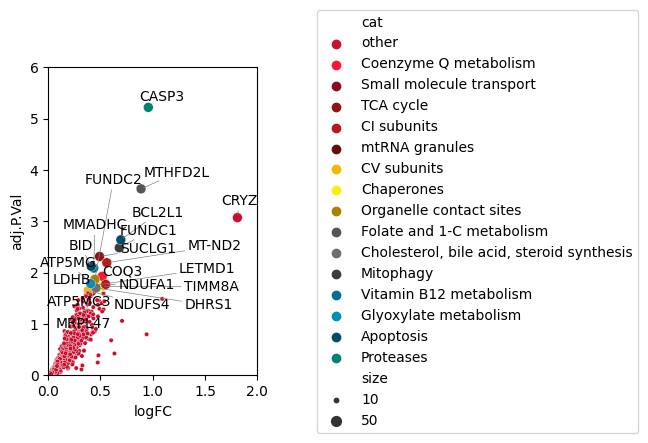

In [377]:
# prep data
data1_mito = data1.loc[df['Symbol'][[x in set(data1.index) for x in df['Symbol']]]]
data1_mito['cat'] = data1_mito['genes'].map(dictionary)
data1_mito['cat'][data1_mito['cat'].isna()] = 'other'
data1_mito[data1_mito['adj.P.Val']>0.05]['cat'] = 'other'

plt.figure(figsize=(2.7, 4))
top_genes = data1_mito.nlargest(20, 'score').index
data1_mito.loc[~data1_mito.index.isin(top_genes), 'cat'] = 'other'

# Your scatterplot
data1_mito['size'] = np.where(data1_mito.index.isin(top_genes), 50, 10)
sns.scatterplot(data=data1_mito, x='logFC', y=-1*np.log10(data1_mito['adj.P.Val']), hue='cat', size='size', sizes=(10, 50), palette=palette)
# Label top genes
texts = []
for gene in top_genes:
    
    if data1_mito.loc[gene, 'adj.P.Val'] < 0.05:
        print(gene)
        txt = plt.text(data1_mito.loc[gene, 'logFC'],
                       -1 * np.log10(data1_mito.loc[gene, 'adj.P.Val']),
                       gene, fontsize=10, ha='right', va='bottom')
        texts.append(txt)

# Adjust text positions to reduce overlap
plt.xlim(0, 2)
plt.ylim(0,6)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center left')
plt.show()


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_61885/1657186307.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data1_mito['cat'][data1_mito['cat'].isna()] = 'other'
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel

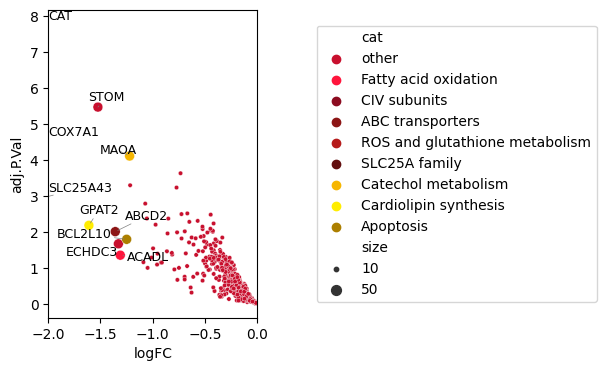

In [341]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from adjustText import adjust_text

data1_mito = data1.loc[df['Symbol'][[x in set(data1.index) for x in df['Symbol']]]]

df['cat'] = [x.split(' |')[0].split('> ')[-1] if isinstance(x, str) else np.NaN for x in df['MitoCarta3.0_MitoPathways'].values]
dictionary = dict(zip(df['Symbol'], df['cat']))

data1_mito['cat'] = data1_mito['genes'].map(dictionary)

data1_mito['cat'][data1_mito['cat'].isna()] = 'other'



data1_mito[data1_mito['adj.P.Val']<0.05]['cat'] = 'other'

plt.figure(figsize=(2.7, 4))
top_genes = data1_mito.nsmallest(10, 'logFC').index

data1_mito.loc[~data1_mito.index.isin(top_genes), 'cat'] = 'other'
# Your scatterplot
data1_mito['size'] = np.where(data1_mito.index.isin(top_genes), 50, 10)
sns.scatterplot(data=data1_mito, x='logFC', y=-1*np.log10(data1_mito['adj.P.Val']), hue='cat', size='size', sizes=(10, 50), palette=palette)

# Label top genes
texts = []
for gene in top_genes:
    if data1_mito.loc[gene, 'adj.P.Val'] < 0.05:
        txt = plt.text(data1_mito.loc[gene, 'logFC'],
                       -1 * np.log10(data1_mito.loc[gene, 'adj.P.Val']),
                       gene, fontsize=9, ha='right', va='bottom')
        texts.append(txt)

# Adjust text positions to reduce overlap
plt.xlim(-2, 0)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center left')
plt.show()


In [149]:
x.sort_values(by='logFC_x', ascending=True)[:50]

,genes_x,logFC_x,AveExpr_x,t_x,P.Value_x,adj.P.Val_x,B_x,score_x,genes_y,logFC_y,AveExpr_y,t_y,P.Value_y,adj.P.Val_y,B_y,score_y,category
genes,,,,,,,,,,,,,,,,,
CAT,CAT,-9.251469,-2.005603,-25.357150,3.984076e-12,1.655830e-08,13.553572,-11.399672,CAT,8.377915,-0.464827,19.164868,2.312056e-13,1.127769e-10,16.247106,12.636002,IMS
COX7A1,COX7A1,-4.593914,-2.700801,-9.750946,3.349631e-07,6.455614e-05,6.441461,-6.475003,COX7A1,3.236254,-2.462194,4.857757,1.289356e-04,1.155157e-03,1.244136,3.889627,MIM
SLC25A43,SLC25A43,-2.253449,-0.278374,-6.381124,2.896392e-05,1.649764e-03,2.791203,-4.538143,SLC25A43,1.489805,-0.185117,4.861642,1.278539e-04,1.147404e-03,1.102539,3.893286,MIM
GPAT2,GPAT2,-1.610503,-0.868233,-5.066137,2.440621e-04,6.613781e-03,0.763160,-3.612500,GPAT2,0.983327,-0.825157,3.238950,4.587916e-03,1.719000e-02,-2.267720,2.338385,MOM
STOM,STOM,-1.524403,3.999877,-13.944854,5.466140e-09,3.428051e-06,11.135883,-8.262319,STOM,0.191752,3.665612,1.987934,6.236122e-02,1.247414e-01,-5.814374,1.205085,Membrane
ABCD2,ABCD2,-1.358543,0.635982,-4.713592,4.500873e-04,9.897359e-03,-0.039977,-3.346703,ABCD2,0.588662,0.536651,2.873459,1.016074e-02,3.120732e-02,-3.324473,1.993074,Membrane
ECHDC3,ECHDC3,-1.328385,0.040476,-4.017498,1.577326e-03,2.154916e-02,-1.181498,-2.802078,ECHDC3,-0.125315,-0.383391,-0.400042,6.938672e-01,7.763343e-01,-6.546691,-0.158724,Matrix
ACADL,ACADL,-1.310221,-0.486255,-3.365642,5.325931e-03,4.467676e-02,-2.276864,-2.273604,ACADL,-0.256775,-1.018369,-0.682906,5.034240e-01,6.170399e-01,-6.239321,-0.298066,MIM
BCL2L10,BCL2L10,-1.249756,-0.274770,-4.276391,9.829372e-04,1.618231e-02,-0.655401,-3.007474,BCL2L10,-0.217534,-0.752440,-0.710494,4.865677e-01,6.006839e-01,-6.282068,-0.312857,MOM


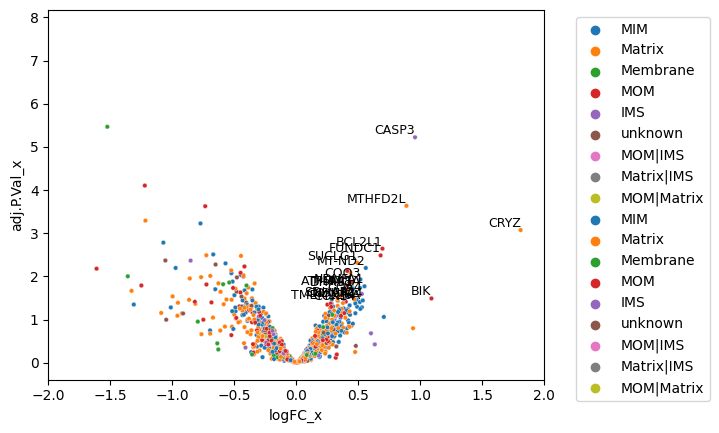

In [121]:
sns.scatterplot(data=x, x='logFC_x', y=-1*np.log10(x['adj.P.Val_x']), hue='category', s = 10)

# Label top genes
top_genes = x.nlargest(30, 'logFC_x').index

for gene in top_genes:
    if x.loc[gene, 'adj.P.Val_x']<0.05:
        plt.text(x.loc[gene, 'logFC_x'], -1*np.log10(x.loc[gene, 'adj.P.Val_x']), gene, fontsize=9, ha='right', va='bottom')

plt.xlim(-2,2)
sns.scatterplot(data=x, x='logFC_x', y=-1*np.log10(x['adj.P.Val_x']), hue='category', s = 10)


# Move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [113]:
x

,genes_x,logFC_x,AveExpr_x,t_x,P.Value_x,adj.P.Val_x,B_x,score_x,genes_y,logFC_y,AveExpr_y,t_y,P.Value_y,adj.P.Val_y,B_y,score_y,category
genes,,,,,,,,,,,,,,,,,
CYC1,CYC1,-0.010086,8.262270,-0.112412,0.912282,0.950910,-7.841391,-0.039871,CYC1,-0.280341,8.119527,-5.007905,0.000093,0.000909,0.010392,-4.030579,MIM
SDHB,SDHB,0.158903,7.299210,1.757461,0.103282,0.256550,-6.285683,0.985974,SDHB,-0.240714,7.226107,-4.359117,0.000384,0.002656,-1.355676,-3.415666,MIM
COQ7,COQ7,0.106409,5.356537,1.009527,0.331864,0.527029,-7.085754,0.479039,COQ7,-0.149634,5.313715,-2.224002,0.039284,0.087394,-5.684523,-1.405785,MIM
SDHA,SDHA,0.062024,5.515638,0.552580,0.590296,0.740710,-7.469801,0.228930,SDHA,-0.155638,5.458298,-2.092805,0.050909,0.106644,-5.940550,-1.293208,MIM
UQCRC1,UQCRC1,-0.105863,9.183046,-1.242216,0.236957,0.428024,-7.127569,-0.625330,UQCRC1,-0.296956,9.005188,-5.323783,0.000047,0.000543,0.636534,-4.323868,MIM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ARMCX6,ARMCX6,0.290565,5.089564,2.848507,0.014157,0.077331,-4.207370,1.849034,ARMCX6,-0.120844,5.111135,-1.803883,0.088134,0.163092,-6.381881,-1.054856,Membrane
METTL4,METTL4,0.027856,3.303517,0.160038,0.875408,0.930969,-7.298622,0.057790,METTL4,-0.014871,3.304112,-0.132596,0.895995,0.930399,-7.610452,-0.047695,Matrix
SPHKAP,SPHKAP,-0.046563,3.818177,-0.303046,0.766839,0.866133,-7.359504,-0.115296,SPHKAP,-0.227022,3.686494,-2.563317,0.019622,0.051498,-4.755112,-1.707268,MIM


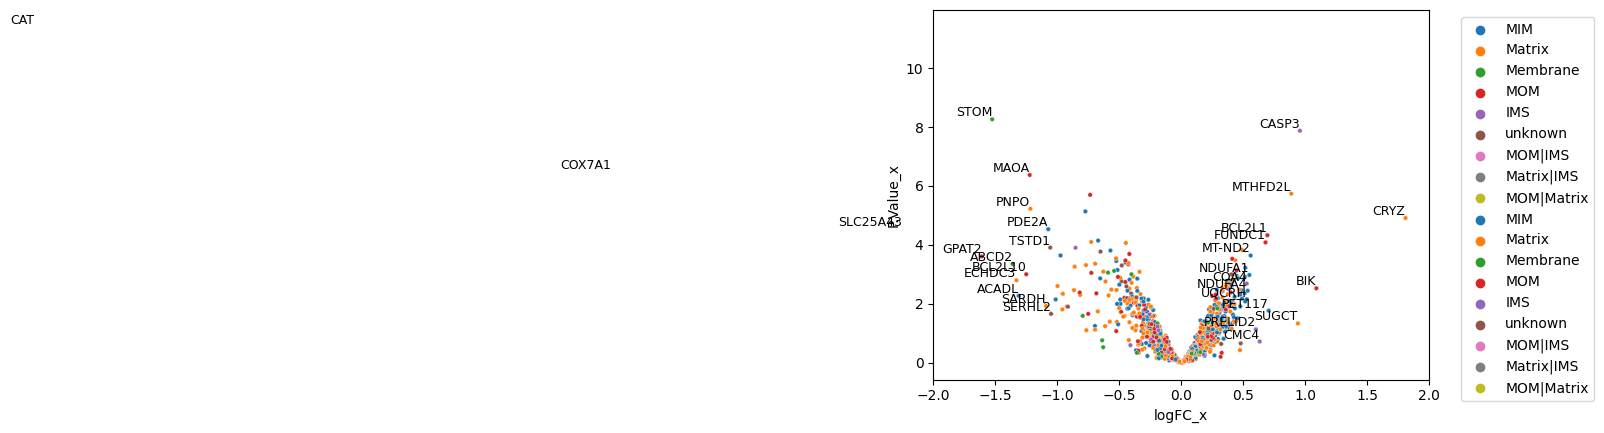

In [112]:
sns.scatterplot(data=x, x='logFC_x', y=-1*np.log10(x['P.Value_x']), hue='category', s = 10)

# Label top genes
top_genes = x.nlargest(15, 'logFC_x').index
bottom_genes = x.nsmallest(15, 'logFC_x').index

for gene in top_genes:
    plt.text(x.loc[gene, 'logFC_x'], -1*np.log10(x.loc[gene, 'P.Value_x']), gene, fontsize=9, ha='right', va='bottom')

for gene in bottom_genes:
    plt.text(x.loc[gene, 'logFC_x'], -1*np.log10(x.loc[gene, 'P.Value_x']), gene, fontsize=9, ha='right', va='bottom')

plt.xlim(-2,2)
sns.scatterplot(data=x, x='logFC_x', y=-1*np.log10(x['P.Value_x']), hue='category', s = 10)


# Move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [45]:
f = data2_mito[data2_mito['adj.P.Val']<0.05]
f.sort_values(by='logFC', ascending=False)[:50]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,score
genes,,,,,,,,
CAT,CAT,8.377915,-0.464827,19.164868,2.312056e-13,1.127769e-10,16.247106,12.636002
COX7A1,COX7A1,3.236254,-2.462194,4.857757,1.289356e-04,1.155157e-03,1.244136,3.889627
KMO,KMO,2.760587,-0.250769,9.711403,1.496525e-08,8.798768e-07,9.839501,7.824916
SLC25A43,SLC25A43,1.489805,-0.185117,4.861642,1.278539e-04,1.147404e-03,1.102539,3.893286
TSTD1,TSTD1,1.423471,4.246444,11.121307,1.841695e-09,1.580587e-07,11.638838,8.734782
PNPO,PNPO,1.339435,3.755787,12.747413,2.084573e-10,2.603329e-08,13.954091,9.680983
BCL2,BCL2,1.164530,1.397172,6.390962,5.290085e-06,9.649643e-05,3.996424,5.276537
FHIT,FHIT,1.119670,5.059994,8.051748,2.352803e-07,8.443164e-06,6.482185,6.628414
AK4,AK4,1.119607,0.286850,3.895826,1.071624e-03,5.761179e-03,-1.077445,2.969958


In [81]:
import statsmodels.stats.multitest as smm
import gseapy as gp

mito_dict = {}
for loc, symbol in zip(df['MitoCarta3.0_MitoPathways'], df['Symbol']):
    mito_dict.setdefault(str(loc), []).append(symbol)

mito_dict.keys()

dict_keys(['OXPHOS > Complex III > CIII subunits | Metabolism > Metals and cofactors > Heme-containing proteins | Metabolism > Electron carriers > Cytochromes | OXPHOS > OXPHOS subunits', 'OXPHOS > Complex II > CII subunits | Metabolism > Carbohydrate metabolism > TCA cycle | Metabolism > Metals and cofactors > Fe-S-containing proteins | OXPHOS > OXPHOS subunits', 'Metabolism > Metals and cofactors > Coenzyme Q metabolism', 'OXPHOS > Complex II > CII subunits | Metabolism > Carbohydrate metabolism > TCA cycle | OXPHOS > OXPHOS subunits', 'Protein import, sorting and homeostasis > Protein import and sorting > Preprotein cleavage | OXPHOS > Complex III > CIII subunits | OXPHOS > OXPHOS subunits', 'Metabolism > Carbohydrate metabolism > Pyruvate metabolism', 'Mitochondrial central dogma > mtRNA metabolism > Transcription | Mitochondrial central dogma > Translation > Mitochondrial ribosome', 'OXPHOS > Complex V > CV subunits | OXPHOS > OXPHOS subunits', 'OXPHOS > Complex IV > CIV subunits 

In [96]:


data1['score'] = -np.log10(data1['P.Value']) * np.sign(data1['logFC'])
rnk = data1[['genes', 'score']].dropna()
rnk.columns = ['gene', 'score']
rnk = rnk.sort_values('score', ascending=False)

pre_res = gp.prerank(
    rnk=rnk,
    gene_sets=mito_dict,
    outdir="gseapy_out",
    permutation_num=1000,
    seed=6,
    min_size=5
)

temp = pre_res.res2d
p_values = temp['NOM p-val']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

# extract leading edge genes
temp = pre_res.res2d
temp = temp.sort_values('FDR')
temp['Term']

0     Mitochondrial central dogma > Translation > Mi...
1     OXPHOS > Complex I > CI subunits | OXPHOS > OX...
2     OXPHOS > Complex V > CV subunits | OXPHOS > OX...
3     OXPHOS > Complex IV > CIV assembly factors | O...
4     OXPHOS > Complex III > CIII subunits | OXPHOS ...
5     OXPHOS > Complex IV > CIV subunits | OXPHOS > ...
6     OXPHOS > Complex IV > CIV assembly factors | M...
7     Metabolism > Nucleotide metabolism > Nucleotid...
8     Metabolism > Lipid metabolism > Cholesterol, b...
9     Metabolism > Vitamin metabolism > Folate and 1...
12    Metabolism > Lipid metabolism > Fatty acid oxi...
13                       Signaling > cAMP-PKA signaling
10    Mitochondrial dynamics and surveillance > Cris...
18    Metabolism > Amino acid metabolism > Branched-...
17             Small molecule transport > SLC25A family
11    Protein import, sorting and homeostasis > Prot...
14    Mitochondrial central dogma > mtDNA maintenanc...
15    OXPHOS > Complex I > CI assembly factors |

In [103]:
temp

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,FDR
0,prerank,Mitochondrial central dogma > Translation > Mi...,0.651249,2.626749,0.0,0.0,0.0,45/75,19.94%,MRPL15;MRPL30;MRPS30;MRPL45;MRPS16;CHCHD1;MRPL...,0.0
1,prerank,OXPHOS > Complex I > CI subunits | OXPHOS > OX...,0.754173,2.576744,0.0,0.0,0.0,32/37,22.32%,MT-ND2;NDUFA1;NDUFS4;NDUFC2;MT-ND1;MT-ND4;NDUF...,0.0
2,prerank,OXPHOS > Complex V > CV subunits | OXPHOS > OX...,0.749931,2.123069,0.0,0.0,0.0,11/17,14.75%,ATP5MC3;ATP5PB;ATP5IF1;ATP5F1A;ATP5PO;ATP5MC2;...,0.0
3,prerank,OXPHOS > Complex IV > CIV assembly factors | O...,0.660736,1.920814,0.003472,0.009162,0.021,11/17,15.91%,COA4;COA6;PET117;COX18;COA5;PET100;COA8;SMIM20...,0.041667
4,prerank,OXPHOS > Complex III > CIII subunits | OXPHOS ...,0.852867,1.748328,0.011869,0.050258,0.136,5/5,14.75%,UQCRH;UQCR10;UQCR11;UQCRB;UQCRQ,0.113947
5,prerank,OXPHOS > Complex IV > CIV subunits | OXPHOS > ...,0.611241,1.660051,0.018657,0.099179,0.284,13/14,15.77%,COX6A1;NDUFA4;COX7A2;COX7C;MT-CO3;COX5A;COX5B;...,0.149254
6,prerank,OXPHOS > Complex IV > CIV assembly factors | M...,0.815378,1.631329,0.032432,0.110688,0.351,2/5,14.67%,SCO1;SCO2,0.222394
7,prerank,Metabolism > Nucleotide metabolism > Nucleotid...,0.491511,1.471946,0.055351,0.259799,0.708,6/20,11.28%,DTYMK;FHIT;PAICS;HINT1;DGUOK;NUDT2,0.332103
8,prerank,"Metabolism > Lipid metabolism > Cholesterol, b...",0.730071,1.458518,0.106383,0.245669,0.733,1/5,1.89%,DHRS1,0.425532
9,prerank,Metabolism > Vitamin metabolism > Folate and 1...,0.681533,1.432802,0.085561,0.248325,0.772,2/6,3.31%,MTHFD2L;MTHFD2,0.425532


Control vs. Y622: t-test independent samples, P_val:1.005e-02 t=4.027e+00
Control vs. G2: t-test independent samples, P_val:5.109e-02 t=2.553e+00


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


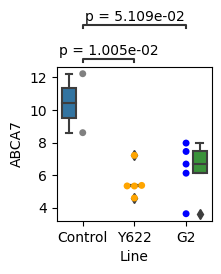

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

gene = 'ABCA7'

plt.figure(figsize=(2, 2))
# Select data for batch 1 and H20 treatment
batch_1_seqids = metadata[metadata['Notes'].str.contains('batch 1')]['SeqID']
line_seqids = metadata[metadata['Treatment'] == 'H20']['SeqID']
common_seqids = np.intersect1d(batch_1_seqids, line_seqids)
counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding.loc[:, common_seqids]

# Create a DataFrame for gene ABCA7; assume gene names are in the index
x = pd.DataFrame(counts_cpm_protein_coding_batch_1.loc[gene])
x['SeqID'] = x.index

# Merge with metadata on 'SeqID'
merged = pd.merge(x, metadata, on='SeqID')

# Create a swarmplot of ABCA7 expression by Line
sns.boxplot(x='Line', y=gene, data=merged, hue='Line')
ax = sns.swarmplot(x='Line', y=gene, data=merged, hue='Line',
                   palette={'Control': 'grey', 'Y622': 'orange', 'G2': 'blue'})

# Define pairs to compare (adjust these as needed)
pairs = [('Control', 'Y622'), ('Control', 'G2')]
# Define the order of the groups; for example, if you want "Control", "Y622", then "G2"
order = ['Control', 'Y622', 'G2']

# Create and configure the Annotator
annotator = Annotator(ax, pairs, data=merged, x='Line', y=gene, order=order)
annotator.configure(test='t-test_ind', text_format='full', loc='outside',
                    verbose=2, show_test_name=False)
annotator.apply_and_annotate()

plt.legend([], [], frameon=False)
plt.show()


In [14]:
data1

NameError: name 'data1' is not defined

In [11]:
merged.groupby('Line')['ABCA7'].mean()

Line
Control    10.415195
G2          6.371452
Y622        5.570735
Name: ABCA7, dtype: float64

In [12]:
 6.371452/10.415195

0.6117458194493718

In [13]:
5.570735/10.415195

0.5348661258862651

Control vs. Y622: t-test independent samples, P_val:8.154e-03 t=4.242e+00
Control vs. G2: t-test independent samples, P_val:1.642e-01 t=1.629e+00


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


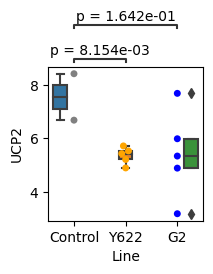

In [651]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

gene = 'UCP2'

plt.figure(figsize=(2, 2))
# Select data for batch 1 and H20 treatment
batch_1_seqids = metadata[metadata['Notes'].str.contains('batch 1')]['SeqID']
line_seqids = metadata[metadata['Treatment'] == 'H20']['SeqID']
common_seqids = np.intersect1d(batch_1_seqids, line_seqids)
counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding.loc[:, common_seqids]

# Create a DataFrame for gene ABCA7; assume gene names are in the index
x = pd.DataFrame(counts_cpm_protein_coding_batch_1.loc[gene])
x['SeqID'] = x.index

# Merge with metadata on 'SeqID'
merged = pd.merge(x, metadata, on='SeqID')

# Create a swarmplot of ABCA7 expression by Line
sns.boxplot(x='Line', y=gene, data=merged, hue='Line')
ax = sns.swarmplot(x='Line', y=gene, data=merged, hue='Line',
                   palette={'Control': 'grey', 'Y622': 'orange', 'G2': 'blue'})

# Define pairs to compare (adjust these as needed)
pairs = [('Control', 'Y622'), ('Control', 'G2')]
# Define the order of the groups; for example, if you want "Control", "Y622", then "G2"
order = ['Control', 'Y622', 'G2']

# Create and configure the Annotator
annotator = Annotator(ax, pairs, data=merged, x='Line', y=gene, order=order)
annotator.configure(test='t-test_ind', text_format='full', loc='outside',
                    verbose=2, show_test_name=False)
annotator.apply_and_annotate()

plt.legend([], [], frameon=False)
plt.show()


In [649]:
data2.loc[['UCP2']]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,score
genes,,,,,,,,
UCP2,UCP2,0.052862,2.455362,0.454185,0.655164,0.744864,-7.308195,0.18365


In [418]:
import pandas as pd
import numpy as np

data1 = pd.read_csv('../../bulkRNAseq/y622_degs.csv', index_col=0)
data2 = pd.read_csv('../../bulkRNAseq/choline_degs.csv', index_col=0)
data3 = pd.read_csv('../../bulkRNAseq/g2_degs.csv', index_col=0)

data1.head()
data2.head()
data1.index = data1['genes']
data2.index = data2['genes']
data3.index = data3['genes']
data1['score'] = -np.log10(data1['P.Value']) * np.sign(data1['logFC'])
data2['score'] = -np.log10(data2['P.Value']) * np.sign(data2['logFC'])
data3['score'] = -np.log10(data3['P.Value']) * np.sign(data3['logFC'])

In [419]:
pathways = np.load('../../processed_data/GO_Biological_Process_2023.npy', allow_pickle=True).item()


In [420]:

# List of keywords to look for
keywords = ['lipid', 'fatty', 'triglyceride', 'cholesterol', 'phosphatidyl']
#keywords = ['choline']
# Filter dictionary: check if any keyword is in the pathway name (case-sensitive)
filtered_pathways = {
    name: details
    for name, details in pathways.items()
    if any(keyword in name for keyword in keywords)
}

print(len(filtered_pathways))
#print(filtered_pathways)


36


In [423]:
temp.iloc[0]['Lead_genes']

'PLA2G3;PLPPR4;PCYT2;PLA2G4C;PNPLA3;ACP6;PLPPR5;PLPP6;PIP4P1;PLAAT3;PLPPR1;PLD2;PLB1;LIPG;PLPPR2;MBOAT2;FADS1;ABHD12;FDFT1;LCP1;PLCD1'

In [421]:

import statsmodels.stats.multitest as smm

data1['score'] = -np.log10(data1['P.Value']) * np.sign(data1['logFC'])
rnk = data1[['genes', 'score']].dropna()
rnk.columns = ['gene', 'score']
rnk = rnk.sort_values('score', ascending=False)

pre_res = gp.prerank(
    rnk=rnk,
    gene_sets=filtered_pathways,
    outdir="gseapy_out",
    permutation_num=1000,
    seed=6,
    min_size=5
)

temp = pre_res.res2d
p_values = temp['NOM p-val']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

# extract leading edge genes
temp = pre_res.res2d
temp = temp.sort_values('FDR')
temp

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,FDR
0,prerank,Phospholipid Metabolic Process (GO:0006644),-0.689123,-2.043449,0.0,0.0,0.0,21/47,11.50%,PLA2G3;PLPPR4;PCYT2;PLA2G4C;PNPLA3;ACP6;PLPPR5...,0.0
1,prerank,Glycerophospholipid Biosynthetic Process (GO:0...,-0.519186,-1.697767,0.0,0.035834,0.048,54/95,32.69%,PLCG2;PCYT2;PLA2G4C;PNPLA3;PITPNM1;ACP6;GPAT2;...,0.0
2,prerank,fatty-acyl-CoA Metabolic Process (GO:0035337),-0.687202,-1.619694,0.010855,0.07034,0.128,6/15,10.17%,FAR2;ACSL3;SLC25A1;FAR1;DGAT2;PPT1,0.095238
3,prerank,Glycerolipid Metabolic Process (GO:0046486),-0.755276,-1.589227,0.015873,0.075981,0.181,4/9,8.54%,PNPLA3;GAL3ST1;DGKB;DGKQ,0.095238
7,prerank,Glycerophospholipid Metabolic Process (GO:0006...,-0.518867,-1.499875,0.013819,0.094893,0.406,11/43,11.75%,PLA2G3;PLA2G4C;PNPLA3;ACP6;PIGZ;FAR1;ABHD3;ABH...,0.095238
4,prerank,Phospholipid Dephosphorylation (GO:0046839),-0.578275,-1.580518,0.022667,0.069278,0.206,17/30,31.86%,PLPPR4;PLPPR5;PLPP6;PIP4P1;PLPPR1;INPP5J;PLPPR...,0.097143
5,prerank,Long-Chain fatty-acyl-CoA Metabolic Process (G...,-0.630466,-1.541386,0.021563,0.087593,0.296,13/19,31.92%,FAR2;ACSL3;FAR1;HACD1;ELOVL1;DGAT2;ELOVL5;HACD...,0.097143
8,prerank,Phospholipid Efflux (GO:0033700),-0.821441,-1.495227,0.028302,0.087888,0.417,2/5,3.02%,APOE;ABCA7,0.106132
6,prerank,Phospholipid Biosynthetic Process (GO:0008654),-0.576088,-1.501731,0.036364,0.106932,0.402,12/23,24.40%,PCYT2;IDI1;FAR1;DHDDS;SRD5A3;FADS1;FDPS;AGPAT5...,0.109091
11,prerank,Phospholipid Transport (GO:0015914),-0.484681,-1.418274,0.033835,0.128514,0.625,18/44,28.46%,PITPNM1;LDLR;ABCB1;APOE;ABCA7;ATP8B3;SCARB1;TM...,0.109091


In [1001]:

import statsmodels.stats.multitest as smm

data2['score'] = -np.log10(data2['P.Value']) * np.sign(data2['logFC'])
rnk = data2[['genes', 'score']].dropna()
rnk.columns = ['gene', 'score']
rnk = rnk.sort_values('score', ascending=False)

pre_res = gp.prerank(
    rnk=rnk,
    gene_sets=filtered_pathways,
    outdir="gseapy_out",
    permutation_num=1000,
    seed=6,
    min_size=5
)

temp = pre_res.res2d
p_values = temp['NOM p-val']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

# extract leading edge genes
temp = pre_res.res2d
temp = temp.sort_values('FDR')

In [1002]:
temp

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,FDR
0,prerank,Glycolipid Metabolic Process (GO:0006664),0.652819,1.788095,0.001425,0.019049,0.012,9/27,13.36%,PGAP1;B3GNT5;UGCG;B4GALNT1;CERK;GALC;B3GALNT1;...,0.015038
1,prerank,fatty-acyl-CoA Metabolic Process (GO:0035337),0.714978,1.676748,0.001504,0.039458,0.05,6/15,11.69%,FAR2;HSD17B4;ACSL4;DGAT2;FAR1;SLC25A1,0.015038
3,prerank,Glycerophospholipid Biosynthetic Process (GO:0...,0.472155,1.582574,0.001225,0.081977,0.191,44/95,27.61%,CHAT;INPPL1;SLC44A5;PITPNM1;DGKB;LPCAT2;OCRL;F...,0.015038
2,prerank,Phospholipid Metabolic Process (GO:0006644),0.542492,1.617743,0.009396,0.075287,0.135,15/47,17.29%,PLCD1;LIPG;PLAAT3;PLPPR4;PLPPR2;ACP6;PLD2;PLBD...,0.07047
6,prerank,Aminophospholipid Transport (GO:0015917),0.785798,1.423453,0.042445,0.210506,0.588,4/5,12.26%,SCARB2;ATP8A2;TMEM30A;ATP8A1,0.230041
7,prerank,Phospholipid Transport (GO:0015914),0.47077,1.403898,0.046008,0.217868,0.651,16/44,19.63%,PITPNM1;ABCB1;SCARB2;ATP8A2;LDLR;PITPNC1;TMEM3...,0.230041
4,prerank,Phospholipid Translocation (GO:0045332),0.562864,1.447976,0.067432,0.240556,0.517,13/20,33.26%,ABCB1;ATP8A2;ANO6;TMEM30A;ATP9A;ATP8A1;ABCA7;A...,0.252869
5,prerank,Phospholipid Catabolic Process (GO:0009395),0.598924,1.435624,0.05997,0.222913,0.553,6/16,10.71%,LIPG;PLD2;PLBD2;ENPP2;SMPDL3A;PLPP6,0.252869
8,prerank,Phospholipid Homeostasis (GO:0055091),0.766057,1.374659,0.087719,0.240828,0.722,3/5,13.62%,LIPG;RCAN3;FABP3,0.262391
9,prerank,Long-Chain fatty-acyl-CoA Metabolic Process (G...,0.538692,1.360376,0.097046,0.242189,0.761,7/19,9.23%,FAR2;ACSL4;HSD17B12;HACD1;DGAT2;FAR1;ELOVL5,0.262391


In [977]:
temp.iloc[1]['Lead_genes']

'PLCG2;PCYT2;PLA2G4C;PNPLA3;PITPNM1;ACP6;GPAT2;LPCAT3;FAR1;INPP4B;PLD2;ETNK2;INPP5J;DGKB;PI4K2B;PI4K2A;MBOAT2;DGKQ;FIG4;INPPL1;PI4KB;ABHD4;MTMR14;SACM1L;MTMR4;CDS1;SLC44A2;SFI1;AGPAT5;IMPA1;GPAT4;MTMR1;VAC14;MBOAT7;ETNK1;PTDSS2;PMPCA;CLN3;MTMR7;PITPNM2;AGPAT2;SLC27A1;ABHD5;MTMR6;MTMR2;DGKE;INPP5K;CHKB;DGKG;MFSD2A;PIP5K1A;MTMR3;GNPAT;CHAT'

In [976]:
temp

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,FDR
0,prerank,Phospholipid Metabolic Process (GO:0006644),-0.689123,-2.043449,0.0,0.0,0.0,21/47,11.50%,PLA2G3;PLPPR4;PCYT2;PLA2G4C;PNPLA3;ACP6;PLPPR5...,0.0
1,prerank,Glycerophospholipid Biosynthetic Process (GO:0...,-0.519186,-1.697767,0.0,0.035834,0.048,54/95,32.69%,PLCG2;PCYT2;PLA2G4C;PNPLA3;PITPNM1;ACP6;GPAT2;...,0.0
2,prerank,fatty-acyl-CoA Metabolic Process (GO:0035337),-0.687202,-1.619694,0.010855,0.07034,0.128,6/15,10.17%,FAR2;ACSL3;SLC25A1;FAR1;DGAT2;PPT1,0.095238
3,prerank,Glycerolipid Metabolic Process (GO:0046486),-0.755276,-1.589227,0.015873,0.075981,0.181,4/9,8.54%,PNPLA3;GAL3ST1;DGKB;DGKQ,0.095238
7,prerank,Glycerophospholipid Metabolic Process (GO:0006...,-0.518867,-1.499875,0.013819,0.094893,0.406,11/43,11.75%,PLA2G3;PLA2G4C;PNPLA3;ACP6;PIGZ;FAR1;ABHD3;ABH...,0.095238
4,prerank,Phospholipid Dephosphorylation (GO:0046839),-0.578275,-1.580518,0.022667,0.069278,0.206,17/30,31.86%,PLPPR4;PLPPR5;PLPP6;PIP4P1;PLPPR1;INPP5J;PLPPR...,0.097143
5,prerank,Long-Chain fatty-acyl-CoA Metabolic Process (G...,-0.630466,-1.541386,0.021563,0.087593,0.296,13/19,31.92%,FAR2;ACSL3;FAR1;HACD1;ELOVL1;DGAT2;ELOVL5;HACD...,0.097143
8,prerank,Phospholipid Efflux (GO:0033700),-0.821441,-1.495227,0.028302,0.087888,0.417,2/5,3.02%,APOE;ABCA7,0.106132
6,prerank,Phospholipid Biosynthetic Process (GO:0008654),-0.576088,-1.501731,0.036364,0.106932,0.402,12/23,24.40%,PCYT2;IDI1;FAR1;DHDDS;SRD5A3;FADS1;FDPS;AGPAT5...,0.109091
11,prerank,Phospholipid Transport (GO:0015914),-0.484681,-1.418274,0.033835,0.128514,0.625,18/44,28.46%,PITPNM1;LDLR;ABCB1;APOE;ABCA7;ATP8B3;SCARB1;TM...,0.109091


### Below is scrap

In [519]:
genes_all = [[ 'MICAL1', 'MICAL3', 'MICAL2', 'MICU1', 'MICALL2', 'MICU2', 'MICALL1', 'MICU3', 'MICOS10', 'MICOS13'],
    ['DRP1', 'GDAP1', 'INF2', 'MFF', 'MFN2', 'MFN1', 'OPA1'],
    [ 'APOE', 'APOD', 'APOO', 'APOLD1', 'APOM', 'APOL2', 'APOC1', 'APOOL'],
    [ 'ABCA7', 'ABCA5', 'ABCA1', 'ABCA10', 'ABCA6', 'ABCA2', 'ABCA3', 'ABCA12'],
    ['SLC44A2', 'SLC44A1', 'SLC44A3', 'SLC44A5'],
    ['SCD', 'SCD5', 'FADS1', 'FADS2', 'FADS3', 'ELOVL2', 'ELOVL5', 'ACSL'],
['CHKA', 'CHKB', 'PCYT1A', 'PCYT1B', 'CHPT1', 'CEPT1', 'PEMT', 'LPCAT1', 'LPCAT2', 'LPCAT3', 'LPCAT4'],
['ACADM', 'ACADVL', 'ACADL', 'CPT1A', 'CPT1B', 'CPT2', 'SLC25A20', 'HADHA', 'HADHB', 'ACAA2', 'ECHS1', 'ETFA', 'ETFB', 'ETFDH'],
['HK1', 'HK2', 'HK3', 'GCK', 'PGI', 'PFKL', 'PFKM', 'PFKP', 'ALDOA', 'ALDOB', 'ALDOC', 'GAPDH', 'PGK1', 'PGAM1', 'PGAM2', 'ENO1', 'ENO2', 'ENO3', 'PKM', 'PKLR'],
['DGAT1', 'DGAT2', 'GPAT1', 'GPAT2', 'GPAT3', 'GPAT4', 'AGPAT1', 'AGPAT2', 'LPIN1', 'LPIN2', 'LPIN3', 'MGLL', 'PNPLA2', 'PNPLA3', 'LPL', 'APOB', 'MTTP', 'ANGPTL3', 'ANGPTL4', 'ANGPTL8', 'CETP', 'FABP1', 'FABP2', 'FABP3']]

In [523]:
genes = genes_all[5]
x = data1.loc[np.array(genes)[[g in data1.index for g in genes]]][['score']]
y = data2.loc[np.array(genes)[[g in data2.index for g in genes]]][['score']]


In [522]:
merged_data

,Y622,Choline
genes,,
GDAP1,-0.864304,0.233449
INF2,-3.898009,0.584116
MFF,1.250986,0.244463
MFN2,-2.204852,2.681944
MFN1,-1.952015,2.809985
OPA1,-0.330525,2.953759


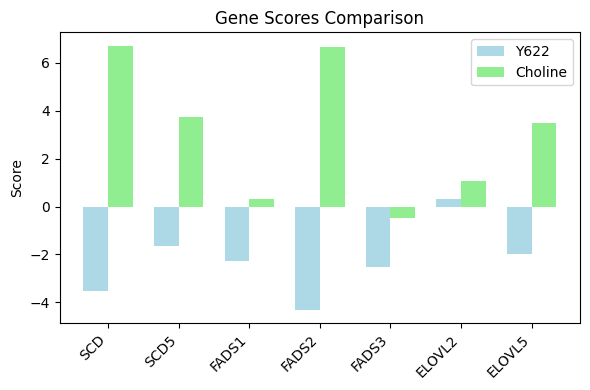

In [524]:
merged_data = pd.merge(x, y, left_index=True, right_index=True)
merged_data.columns = ['Y622', 'Choline']

plt.figure(figsize=(6, 4))
bar_width = 0.35
x_pos = np.arange(len(merged_data.index))

plt.bar(x_pos - bar_width/2, merged_data['Y622'], bar_width, label='Y622', color='lightblue')
plt.bar(x_pos + bar_width/2, merged_data['Choline'], bar_width, label='Choline', color='lightgreen')

plt.xticks(x_pos, merged_data.index, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Gene Scores Comparison')
plt.legend()
plt.tight_layout()
plt.show()

In [426]:
data1.loc[]

IndexingError: Too many indexers

In [503]:
data1[data1.index.str.startswith('MIC')]['genes']

genes
MICAL1      MICAL1
MICAL3      MICAL3
MICAL2      MICAL2
MICU1        MICU1
MICALL2    MICALL2
MICU2        MICU2
MICALL1    MICALL1
MICU3        MICU3
MICOS10    MICOS10
MICOS13    MICOS13
Name: genes, dtype: object

In [918]:
data3.loc[['MFN1', 'MFN2', 'DNM1L']]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,score
genes,,,,,,,,
MFN1,MFN1,-0.247719,4.203945,-1.351608,0.202624,0.539102,-6.212386,-0.693310
MFN2,MFN2,-0.401164,6.428368,-1.833382,0.092878,0.422158,-5.723536,-1.032085
DNM1L,DNM1L,-0.297898,7.539003,-1.607936,0.135080,0.473897,-6.111154,-0.869407


In [414]:
data1.loc[['CHKA', 'CHKB', 'PCYT1B', 'CEPT1', 'PEMT', 'LPCAT1', 'LPCAT2', 'LPCAT3', 'LPCAT4']]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
genes,,,,,,,
CHKA,CHKA,-0.041077,5.926654,-0.388762,0.703993,0.822314,-7.593317
CHKB,CHKB,-0.462188,-0.179943,-1.563658,0.142850,0.315926,-5.322544
PCYT1B,PCYT1B,0.004241,5.138743,0.035358,0.972353,0.985371,-7.592860
CEPT1,CEPT1,0.113672,4.511640,0.898632,0.385831,0.576184,-7.083543
PEMT,PEMT,0.202663,5.557004,1.671607,0.119429,0.281174,-6.272126
LPCAT1,LPCAT1,-0.003767,6.066344,-0.032053,0.974936,0.987078,-7.684035
LPCAT2,LPCAT2,-0.293837,0.944482,-1.271889,0.226566,0.415813,-5.970962
LPCAT3,LPCAT3,-0.536861,3.753375,-4.156753,0.001222,0.018498,-1.599943
LPCAT4,LPCAT4,-0.283146,4.992760,-2.789747,0.015816,0.082526,-4.332430


In [472]:
pathways = np.load('../../processed_data/all_paths.npy', allow_pickle=True).item()

In [569]:
# Load specific tab from Excel file
data2 = pd.read_excel('../../../../Downloads/Human.MitoCarta3.0.xls', sheet_name='C MitoPathways')


In [570]:
data2 = data2.dropna()

In [572]:
data2['MitoPathway']

0      Mitochondrial central dogma
1                mtDNA maintenance
2                mtDNA replication
3                   mtDNA nucleoid
4                     mtDNA repair
                  ...             
144                      Mitophagy
145                      Autophagy
146                      Apoptosis
147              Cristae formation
148                  MICOS complex
Name: MitoPathway, Length: 148, dtype: object

In [558]:
dictionary = dict(zip(data2['MitoPathway'], [x.split(', ') for x in data2['Genes']]))

In [391]:
# Define lipid-related keywords
lipid_keywords = ['phospholipid']

# Filter pathways dictionary to only keep lipid-related pathways
lipid_pathways = {}
for pathway_name, genes in pathways.items():
    if any(keyword.lower() in pathway_name.lower() for keyword in lipid_keywords):
        lipid_pathways[pathway_name] = genes

print(f"Found {len(lipid_pathways)} lipid-related pathways out of {len(pathways)} total pathways")
#lipid_pathways


Found 17 lipid-related pathways out of 5406 total pathways


In [378]:
# Convert pathways into a list of lists
pathway_lists = [
    ['SCD', 'SCD5', 'FADS1', 'FADS2', 'FADS3', 'ELOVL2', 'ELOVL5', 'ACSL'],
    ['CHKA', 'CHKB', 'PCYT1A', 'PCYT1B', 'CHPT1', 'CEPT1', 'PEMT', 'LPCAT1', 'LPCAT2', 'LPCAT3', 'LPCAT4'],
    ['ACADM', 'ACADVL', 'ACADL', 'CPT1A', 'CPT1B', 'CPT2', 'SLC25A20', 'HADHA', 'HADHB', 'ACAA2', 'ECHS1', 'ETFA', 'ETFB', 'ETFDH'],
    ['HK1', 'HK2', 'HK3', 'GCK', 'PGI', 'PFKL', 'PFKM', 'PFKP', 'ALDOA', 'ALDOB', 'ALDOC', 'GAPDH', 'PGK1', 'PGAM1', 'PGAM2', 'ENO1', 'ENO2', 'ENO3', 'PKM', 'PKLR'],
    ['DGAT1', 'DGAT2', 'GPAT1', 'GPAT2', 'GPAT3', 'GPAT4', 'AGPAT1', 'AGPAT2', 'LPIN1', 'LPIN2', 'LPIN3', 'MGLL', 'PNPLA2', 'PNPLA3', 'LPL', 'APOB', 'MTTP', 'ANGPTL3', 'ANGPTL4', 'ANGPTL8', 'CETP', 'FABP1', 'FABP2', 'FABP3']
]

# Create descriptive names for each pathway
pathway_names = [
    'Fatty Acid Desaturation and Elongation',
    'Phosphatidylcholine Synthesis',
    'Fatty Acid Beta Oxidation',
    'Glycolysis',
    'Triglyceride Synthesis and Transport'
]

# Create dictionary mapping pathway names to gene lists
pathway_dict = dict(zip(pathway_names, pathway_lists))


In [478]:
data1 = data2

In [566]:
import numpy as np
import pandas as pd
import gseapy as gp
data1 = data2
data1['score'] = -np.log10(data1['P.Value']) * np.sign(data1['logFC'])
rnk = data1[['genes', 'score']].dropna()
rnk.columns = ['gene', 'score']
rnk = rnk.sort_values('score', ascending=False)

pre_res = gp.prerank(
    rnk=rnk,
    gene_sets=dictionary,
    outdir="gseapy_out",
    permutation_num=1000,  # For more robust results, increase this number.
    seed=6,
    min_size=5
)


In [567]:
# Get results from prerank analysis
temp = pre_res.res2d
import numpy as np
import statsmodels.stats.multitest as smm

# Example list of raw p-values
p_values = temp['NOM p-val']

# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')

temp['FDR'] = fdr_corrected_pvals


In [568]:
temp = pre_res.res2d
# Sort by FDR q-value (NES_FDR column)
temp = temp.sort_values('FDR')
temp[temp['FDR']<0.1]


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,FDR
0,prerank,Mitochondrial ribosome,-0.682621,-2.651795,0.0,0.0,0.0,48/81,18.38%,MRPL16;MRPL37;MRPL14;MRPL15;MRPS7;MRPS18A;MRPL...,0.0
16,prerank,Fe-S-containing proteins,-0.55334,-1.752714,0.0,0.024871,0.19,13/30,20.74%,UQCRFS1;ISCA2;SDHB;ISCU;NDUFV1;NDUFS2;NTHL1;LI...,0.0
15,prerank,mtRNA metabolism,-0.452224,-1.75877,0.0,0.024563,0.179,28/76,19.28%,MTPAP;TEFM;MTERF1;TRUB2;MRPS7;TFB1M;MRM3;RMND1...,0.0
24,prerank,"Protein import, sorting and homeostasis",-0.423449,-1.624241,0.0,0.053121,0.486,23/82,14.09%,CASP3;TIMM21;OMA1;TIMM17B;UQCRC1;TIMM23;TOMM5;...,0.0
10,prerank,Complex IV,-0.530123,-1.829728,0.0,0.01761,0.09,27/46,23.24%,COX7A2;TIMM21;COX16;COX6A1;COA7;COA3;COA6;COX7...,0.0
8,prerank,CIV assembly factors,-0.601559,-1.889221,0.0,0.010555,0.047,15/30,19.84%,TIMM21;COX16;COA7;COA3;COA6;COX14;SURF1;CMC2;C...,0.0
18,prerank,Complex I,-0.466114,-1.722353,0.0,0.030292,0.257,43/66,25.05%,NDUFB8;NDUFA12;FOXRED1;NDUFA6;NDUFA1;MT-ND4L;N...,0.0
5,prerank,OXPHOS assembly factors,-0.563531,-2.103653,0.0,0.000931,0.003,36/68,19.84%,TIMM21;COX16;FOXRED1;BCS1L;COA7;COA3;RAB5IF;CO...,0.0
4,prerank,OXPHOS subunits,-0.536685,-2.159261,0.0,0.000373,0.001,43/95,16.84%,UQCRFS1;COX7A2;NDUFB8;UQCRC1;UQCR10;NDUFA12;CO...,0.0
3,prerank,Translation,-0.541686,-2.268644,0.0,0.000466,0.001,74/151,21.16%,MTERF3;TIMM21;MRPL16;MRPL37;MRPL14;MRPL15;MRPS...,0.0


In [573]:
temp = pre_res.res2d
# Sort by FDR q-value (NES_FDR column)
temp = temp.sort_values('FDR')
temp[temp['NOM p-val']<0.05]


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,FDR
0,prerank,Mitochondrial ribosome,-0.682621,-2.651795,0.0,0.0,0.0,48/81,18.38%,MRPL16;MRPL37;MRPL14;MRPL15;MRPS7;MRPS18A;MRPL...,0.0
16,prerank,Fe-S-containing proteins,-0.55334,-1.752714,0.0,0.024871,0.19,13/30,20.74%,UQCRFS1;ISCA2;SDHB;ISCU;NDUFV1;NDUFS2;NTHL1;LI...,0.0
15,prerank,mtRNA metabolism,-0.452224,-1.75877,0.0,0.024563,0.179,28/76,19.28%,MTPAP;TEFM;MTERF1;TRUB2;MRPS7;TFB1M;MRM3;RMND1...,0.0
24,prerank,"Protein import, sorting and homeostasis",-0.423449,-1.624241,0.0,0.053121,0.486,23/82,14.09%,CASP3;TIMM21;OMA1;TIMM17B;UQCRC1;TIMM23;TOMM5;...,0.0
10,prerank,Complex IV,-0.530123,-1.829728,0.0,0.01761,0.09,27/46,23.24%,COX7A2;TIMM21;COX16;COX6A1;COA7;COA3;COA6;COX7...,0.0
8,prerank,CIV assembly factors,-0.601559,-1.889221,0.0,0.010555,0.047,15/30,19.84%,TIMM21;COX16;COA7;COA3;COA6;COX14;SURF1;CMC2;C...,0.0
18,prerank,Complex I,-0.466114,-1.722353,0.0,0.030292,0.257,43/66,25.05%,NDUFB8;NDUFA12;FOXRED1;NDUFA6;NDUFA1;MT-ND4L;N...,0.0
5,prerank,OXPHOS assembly factors,-0.563531,-2.103653,0.0,0.000931,0.003,36/68,19.84%,TIMM21;COX16;FOXRED1;BCS1L;COA7;COA3;RAB5IF;CO...,0.0
4,prerank,OXPHOS subunits,-0.536685,-2.159261,0.0,0.000373,0.001,43/95,16.84%,UQCRFS1;COX7A2;NDUFB8;UQCRC1;UQCR10;NDUFA12;CO...,0.0
3,prerank,Translation,-0.541686,-2.268644,0.0,0.000466,0.001,74/151,21.16%,MTERF3;TIMM21;MRPL16;MRPL37;MRPL14;MRPL15;MRPS...,0.0


In [477]:
temp[temp['FDR']<0.05]['Lead_genes'].to_list()

['RPS12;RPL21;RPS15A;RPS3A;RPL15;RPS2;RPSA;RPS18;RPS6KA3;RPS23;RPL5;RPL23A;RPS6;RPS13;RPS27A;RPL7;RPL3;RPS28;RPS5;RPS25;RPL18;RPLP0;RPL22;RPL31;RPL37;RPL7A;RPL11;RPL12;RPL18A;RPL34;RPL13A;RPL4;RPL39;RPL41;RPL9;RPL30;RPL26;RPL27A;RPS8;RPL17;RPS17;RPL10;RPL29;RPS3;RPS27;RPLP2;RPL14;RPS21;RPL8;RPL32;RPL24;RPS19;RPL38;RPS16;RPS11;UBA52;RPL19;RPL23;RPS29;RPL13;RPLP1;RPS20;RPS14;RPL35A;RPL37A;FAU;RPL6;RPS4X;RPL27;RPS26;RPS24;RPL36;RPL28;RPL10A;RPS10;RPS15;RPS9;RPL35',
 'CREB3L4;PRIM1;CCND1;CCND2;CCNH;PRIM2;MNAT1;CDKN2C;CDKN1B;RPA3;CDKN1C;CDK4;ATM;CDK7;TFDP2;GADD45A;MCM7;POLE2;ORC5;TP53;ORC4;CDKN2B',
 'MVD;ACAT2;MVK;HMGCR;HMGCS1;FDPS',
 'EEF1A1;EIF3H;PABPC1;EIF3E;EIF3F;EEF1B2;EIF4A2;EIF6;EIF1AX;EIF3J;EIF1;EIF4B',
 'SLC29A1;FOS;CST3;DRD2;HCRTR1;TH;DLAT;PER3;UTS2;ADORA1;CACNA1I;HCRTR2',
 'CYP1B1;CYP51A1;CYP2S1;CYB5R3;CYP27A1;POR;CYP4A11;CYB5B;CYP46A1;CYP4X1;CYP4V2',
 'TAF9;POLR2K;GTF2A2;POLR1E;CCNH;POLR3K;GTF2F2;POLR2I;POLR2H;GTF2B;MNAT1;POLR2G;POLR2J;CDK7;POLR3D;TAF12',
 'ME1;FADS2;FABP3;ACSL3

In [482]:
temp[temp['FDR']<0.05]['Lead_genes'].to_list()

['UQCRFS1;COX7A2;NDUFB8;UQCRC1;UQCR10;NDUFA12;COX6A1;NDUFA6;NDUFA1;ATP5F1C;SDHB;ATP5IF1;COX7A2L;NDUFS4;NDUFA10;UQCRH;NDUFB3;SDHD;ATP5MG;COX5B;ATP5PB;NDUFV1;ATP5F1A;NDUFA4;SDHC;SURF1;NDUFB6;NDUFS2;ATP5PF;SLC25A14;SLC25A4;NDUFB7;UQCR11;NDUFS3;NDUFB9;COX4I1;NDUFB2;COX7B;ATP5PO;NDUFC2;COX5A;SDHA;NDUFAB1',
 'ITGA6;MAP2K5;VCL;ITGAV;CAPN1;PAK4;PAK1;CAV2;GIT2;ITGA9;SRC;SOS1;MAPK6;CRK;VAV2;CAPN10;CAPN2;MAPK1;ITGB1;RAP1A;RAPGEF1;MAP2K6;ITGB8;AKT3;ARHGEF7;MAP2K1;BRAF;SHC3;MAPK4;ZYX;CAPNS1;ITGA1;GRB2;MAP2K3;MAPK12;AKT1;ITGA2B;MAPK10;PTK2;TNS1;RAF1;HRAS;PAK3',
 'DVL3;MAPK8;MAPK9;WNT4;FZD6;WNT10B;FZD7;FZD9;FZD3;RHOA;FZD5;WNT5A;CTNNB1;LRP6',
 'GRM7;GRM3;GPRC5C;GRM2;GRM4;GPRC5B',
 'UQCRFS1;CASP3;COX7A2;JUN;BID;PIK3R1;NDUFB8;UQCRC1;UQCR10;NDUFA12;COX6A1;CYC1;INSR;NDUFA6;NDUFA1;SDHB;COX7A2L;NDUFS4;NDUFA10;NR1H3;UQCRH;DDIT3;NDUFB3;SDHD;COX5B;XBP1;NDUFV1;PRKAB1;NDUFA4;SDHC;NDUFB6;NDUFS2;NDUFB7;UQCR11;NDUFS3;NDUFB9;COX4I1;NDUFB2;COX7B;UQCRHL;NDUFA13;PIK3CA;NDUFC2;COX5A;SDHA',
 'TAF9;POLR1E;POLR3K;CDK7;TAF1

In [314]:


# Step 1: Load your expression data into a DataFrame.
# Replace 'data2.csv' with your actual data file.
data2 = pd.read_csv('data2.csv')

# Step 2: Calculate the score as specified:
# score = log2(P.Value) * sign(logFC)
# (Note: Make sure your P.Values are >0 so that log2 is defined.)
data2['score'] = -np.log2(data2['P.Value']) * np.sign(data2['logFC'])

# Step 3: Prepare a ranked list.
# It is assumed that your DataFrame has a column 'gene' for gene names.
# The ranked list should be sorted by the score in descending order.
rnk = data2[['gene', 'score']].dropna()
rnk = rnk.sort_values('score', ascending=False)

# Optionally, you can save the ranked list to a file in .rnk format,
# which is required by gseapy.prerank (a two-column, tab-delimited file).
rnk.to_csv("ranked_genes.rnk", sep="\t", index=False, header=False)

# Step 4: Load your pathways (gene sets) from a NumPy file.
# The file 'pathways.npy' should contain a dictionary with pathway names as keys
# and a list of gene names as values.
pathways = np.load('pathways.npy', allow_pickle=True).item()

# Step 5: Run GSEApy prerank.
# Adjust permutation_num and other parameters as needed.
pre_res = gp.prerank(
    rnk="ranked_genes.rnk",
    gene_sets=pathways,
    outdir="gseapy_out",
    permutation_num=100,  # For more robust results, increase this number.
    seed=6
)

# Print the top results
print(pre_res.res2d.head())


FileNotFoundError: [Errno 2] No such file or directory: 'data2.csv'

In [948]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

plt.figure(figsize=(2, 2))
# Select data for batch 1 and H20 treatment
batch_1_seqids = metadata[metadata['Notes'].str.contains('batch 1')]['SeqID']
line_seqids = metadata[metadata['Treatment'] == 'H20']['SeqID']
common_seqids = np.intersect1d(batch_1_seqids, line_seqids)
counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding.loc[:, common_seqids]

# Create a DataFrame for gene ABCA7; assume gene names are in the index
x = pd.DataFrame(counts_cpm_protein_coding_batch_1.loc['ABCA7'])
x['SeqID'] = x.index

# Merge with metadata on 'SeqID'
merged = pd.merge(x, metadata, on='SeqID')

# Create a swarmplot of ABCA7 expression by Line
ax = sns.swarmplot(x='Line', y='ABCA7', data=merged, hue='Line',
                   palette={'Control': 'grey', 'Y622': 'orange', 'G2': 'blue'})

# Define pairs to compare (adjust these as needed)
pairs = [('Control', 'Y622'), ('Control', 'G2')]
# Define the order of the groups; for example, if you want "Control", "Y622", then "G2"
order = ['Control', 'Y622', 'G2']

# Create and configure the Annotator
annotator = Annotator(ax, pairs, data=merged, x='Line', y='ABCA7', order=order)
annotator.configure(test='t-test_ind', text_format='full', loc='outside',
                    verbose=2, show_test_name=False)
annotator.apply_and_annotate()

plt.legend([], [], frameon=False)
plt.show()


ValueError: 'SeqID' is both an index level and a column label, which is ambiguous.

<Figure size 200x200 with 0 Axes>

In [167]:
metadata.index = metadata['SeqID']

In [203]:
data2.index = data2['genes']

In [251]:
data2.loc[['MFN1', 'MFN2', 'DNM1L']]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,score
genes,,,,,,,,
MFN1,MFN1,0.328352,4.195592,3.729983,0.001549,0.007561,-2.378961,-9.334570
MFN2,MFN2,0.317922,6.415288,3.597135,0.002080,0.009495,-2.976396,-8.909224
DNM1L,DNM1L,0.187812,7.517285,2.211825,0.040250,0.088808,-5.924745,-4.634864


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_15542/1956088963.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


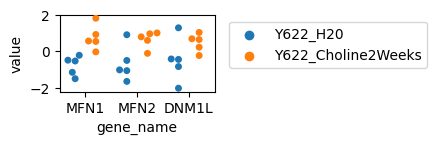

In [258]:
# Select data for batch 1 and H20 treatment
batch_1_seqids = metadata[metadata['Notes'].str.contains('batch 1')]['SeqID']
line_seqids = metadata[metadata['Line'] == 'Y622']['SeqID']
common_seqids = np.intersect1d(batch_1_seqids, line_seqids)
counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding.loc[:, common_seqids]
counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding_batch_1.loc[['MFN1', 'MFN2', 'DNM1L']]

counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding_batch_1.sub(
    counts_cpm_protein_coding_batch_1.mean(axis=1), axis=0
).div(
    counts_cpm_protein_coding_batch_1.std(axis=1), axis=0
)

counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding_batch_1.T
x = metadata.loc[counts_cpm_protein_coding_batch_1.index]
counts_cpm_protein_coding_batch_1['line'] = x['Line']
counts_cpm_protein_coding_batch_1['treatment'] = x['Treatment']

counts_cpm_protein_coding_batch_1 = pd.melt(counts_cpm_protein_coding_batch_1, id_vars=['line', 'treatment'], value_vars=counts_cpm_protein_coding_batch_1.columns)

counts_cpm_protein_coding_batch_1['grp'] = counts_cpm_protein_coding_batch_1['line'] + '_' + counts_cpm_protein_coding_batch_1['treatment']


plt.figure(figsize=(2, 1))
sns.swarmplot(x='gene_name', y='value', data=counts_cpm_protein_coding_batch_1, hue='grp', dodge=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


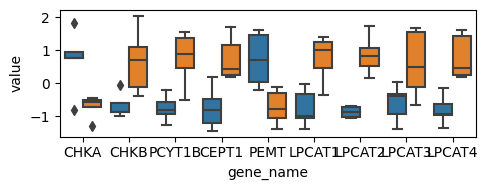

In [250]:
# Select data for batch 1 and H20 treatment
batch_1_seqids = metadata[metadata['Notes'].str.contains('batch 1')]['SeqID']
line_seqids = metadata[metadata['Line'] == 'Y622']['SeqID']
common_seqids = np.intersect1d(batch_1_seqids, line_seqids)
counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding.loc[:, common_seqids]
counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding_batch_1.loc[['CHKA', 'CHKB', 'PCYT1B', 'CEPT1', 'PEMT', 'LPCAT1', 'LPCAT2', 'LPCAT3', 'LPCAT4']]

counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding_batch_1.sub(
    counts_cpm_protein_coding_batch_1.mean(axis=1), axis=0
).div(
    counts_cpm_protein_coding_batch_1.std(axis=1), axis=0
)

counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding_batch_1.T
x = metadata.loc[counts_cpm_protein_coding_batch_1.index]
counts_cpm_protein_coding_batch_1['line'] = x['Line']
counts_cpm_protein_coding_batch_1['treatment'] = x['Treatment']

counts_cpm_protein_coding_batch_1 = pd.melt(counts_cpm_protein_coding_batch_1, id_vars=['line', 'treatment'], value_vars=counts_cpm_protein_coding_batch_1.columns)

counts_cpm_protein_coding_batch_1['grp'] = counts_cpm_protein_coding_batch_1['line'] + '_' + counts_cpm_protein_coding_batch_1['treatment']


plt.figure(figsize=(5, 2))
sns.boxplot(x='gene_name', y='value', data=counts_cpm_protein_coding_batch_1, hue='grp')
plt.legend().remove()
plt.tight_layout()


In [241]:
data1.index = data1['genes']

In [243]:
data2.loc[['CHKA', 'CHKB', 'PCYT1A', 'PCYT1B', 'CHPT1', 'CEPT1', 'PEMT', 'LPCAT1', 'LPCAT2', 'LPCAT3', 'LPCAT4']]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,score
genes,,,,,,,,
CHKA,CHKA,-0.190555,5.818572,-2.830800,0.011135,0.033582,-4.558723,6.488719
CHKB,CHKB,0.650668,0.017244,2.568974,0.019391,0.051106,-3.805171,-5.688480
PCYT1A,PCYT1A,-0.151971,3.736764,-1.602655,0.126539,0.217051,-6.448413,2.982347
PCYT1B,PCYT1B,0.301386,5.284164,3.939732,0.000972,0.005361,-2.090959,-10.006656
CHPT1,CHPT1,-0.089040,6.249736,-1.541826,0.140638,0.234792,-6.917653,2.829942
CEPT1,CEPT1,0.312544,4.704705,3.728636,0.001554,0.007572,-2.471126,-9.330255
PEMT,PEMT,-0.195513,5.518065,-2.901862,0.009558,0.029904,-4.375961,6.709063
LPCAT1,LPCAT1,0.334958,6.227937,4.309574,0.000428,0.002873,-1.376837,-11.188844
LPCAT2,LPCAT2,1.288040,1.522171,6.823165,0.000002,0.000049,4.834189,-18.748726


In [174]:
counts_cpm_protein_coding_batch_1['grp'] = counts_cpm_protein_coding_batch_1['line'] + '_' + counts_cpm_protein_coding_batch_1['treatment']

In [191]:
counts_cpm_protein_coding_batch_1.head()

,line,treatment,gene_name,value,grp
0,Control,H20,MFN1,20.938322,Control_H20
1,Control,H20,MFN1,20.727382,Control_H20
2,Y622,H20,MFN1,17.037154,Y622_H20
3,Y622,H20,MFN1,15.352705,Y622_H20
4,Y622,H20,MFN1,14.399624,Y622_H20


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


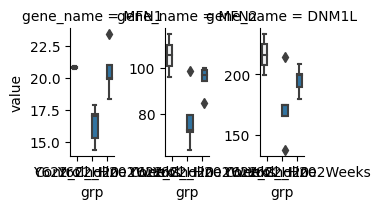

In [190]:
g = sns.FacetGrid(
    counts_cpm_protein_coding_batch_1,
    col='gene_name',
    sharex=False,
    sharey=False,
    height=2,      # height of each facet (in inches)
    aspect=0.5       # width/height ratio of each facet
)
g.map_dataframe(sns.boxplot, x='grp', y='value', hue='line')


In [311]:
np.log2(0.1)

-3.321928094887362

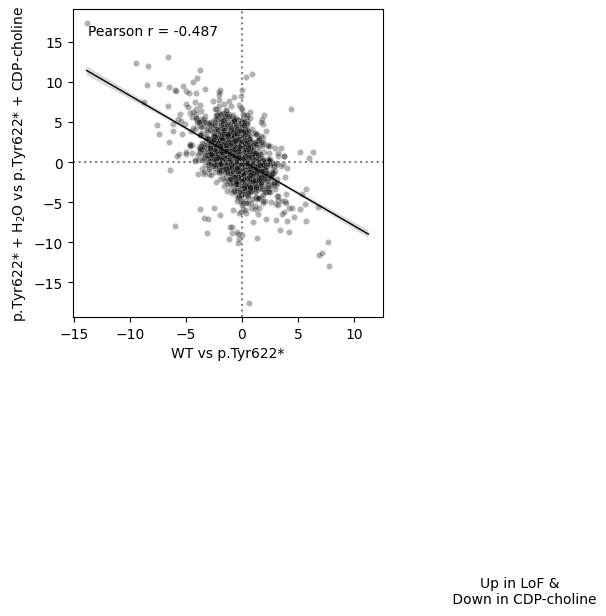

In [366]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import stack_data  # Adjust this to your module's data-loading function

data1['score'] = -np.log10(data1['P.Value']) * np.sign(data1['logFC'])
data2['score'] = -np.log10(data2['P.Value']) * np.sign(data2['logFC'])

data_merged = pd.merge(data1, data2, left_index=True, right_index=True)


plt.figure(figsize=(4, 4))

# Create a random subsample (e.g., 10% of the points)
sample_df = data_merged.sample(frac=0.2, random_state=42)

# Plot the regression line using the full dataset without scatter points
sns.regplot(x='score_x', y='score_y', data=data_merged, scatter=False, ci=95, color='black', line_kws={'linewidth': 1})

# Overlay scatter points from the subsample
sns.scatterplot(x='score_x', y='score_y', data=sample_df, color='black', alpha=0.3, s=20)

# Calculate Pearson correlation coefficient and p-value
r, p = stats.pearsonr(data_merged['score_x'], data_merged['score_y'])

# Add text annotation with the correlation coefficient
plt.text(0.05, 0.95, f'Pearson r = {r:.3f}',
         transform=plt.gca().transAxes, verticalalignment='top')

# Add horizontal and vertical dotted lines at zero
plt.axhline(y=0, color='grey', linestyle='dotted')
plt.axvline(x=0, color='grey', linestyle='dotted')

plt.xlabel('WT vs p.Tyr622*')
plt.ylabel('p.Tyr622* + H$_2$O vs p.Tyr622* + CDP-choline')
# Add arrow in lower right quadrant
plt.annotate('', xy=(50, -60), xytext=(20, -60),
             arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8))
plt.text(25, -55, 'Up in LoF & \n Down in CDP-choline', ha='center')

plt.savefig('../../paper/main_plots/rna_correlation_plot.png', bbox_inches='tight')

plt.show()


In [264]:
data_merged['score_x'].values

array([ 4.60035812e+01,  4.24418036e+01,  3.78688921e+01, ...,
        6.83807812e-04, -5.77856573e-04, -6.87487687e-05])

In [271]:
data_merged['score_x2'] = -1*data_merged['score_x']
data_merged['S'] = data_merged[['score_x2','score_y']].mean(axis=1)

# Sort data_merged by S column in descending order
data_merged = data_merged.sort_values('S', ascending=False)


In [275]:
data_merged[-20:]

,genes_x,logFC_x,AveExpr_x,t_x,P.Value_x,adj.P.Val_x,B_x,score_x,genes_y,logFC_y,AveExpr_y,t_y,P.Value_y,adj.P.Val_y,B_y,score_y,S,score_x2
ENSG00000171551.12,ECEL1,-0.753956,5.766764,-7.026581,1.109785e-05,7.986810e-04,3.058038,16.459361,ECEL1,1.377586,6.237926,20.327393,8.433432e-14,4.866707e-11,21.751077,-43.430873,-29.945117,-16.459361
ENSG00000163297.18,ANTXR2,-2.329199,2.275820,-14.511808,3.412380e-09,2.496724e-06,11.660240,28.126575,ANTXR2,1.841740,2.530562,12.743366,2.095314e-10,2.603329e-08,14.117763,-32.152114,-30.139345,-28.126575
ENSG00000164756.13,SLC30A8,-6.409202,-0.271344,-16.369277,8.122650e-10,8.914609e-07,12.031733,30.197330,SLC30A8,4.667823,0.219909,12.940889,1.632928e-10,2.194455e-08,13.817493,-32.511820,-31.354575,-30.197330
ENSG00000145248.7,SLC10A4,-0.917822,6.128881,-9.904938,2.812014e-07,5.973262e-05,6.897667,21.761893,SLC10A4,1.206352,6.469977,20.318199,8.499185e-14,4.866707e-11,21.726210,-43.419669,-32.590781,-21.761893
ENSG00000115665.9,SLC5A7,-1.019677,3.714263,-7.221425,8.397098e-06,6.675014e-04,3.553619,16.861678,SLC5A7,2.360435,4.602515,24.968039,2.410090e-15,2.645074e-12,25.453821,-48.559834,-32.710756,-16.861678
ENSG00000106829.21,TLE4,-0.729269,5.978892,-7.364115,6.866947e-06,5.677653e-04,3.547516,17.151900,TLE4,1.488748,6.513011,25.308668,1.903781e-15,2.279345e-12,25.626032,-48.900054,-33.025977,-17.151900
ENSG00000187714.7,SLC18A3,-1.206589,4.742754,-10.378404,1.663964e-07,4.134795e-05,7.542662,22.518872,SLC18A3,1.815559,5.300972,21.399772,3.483130e-14,2.597274e-11,22.728260,-44.706609,-33.612741,-22.518872
ENSG00000159176.14,CSRP1,-1.352676,5.498786,-14.301277,4.056906e-09,2.671472e-06,11.363133,27.876973,CSRP1,1.232872,5.726299,17.655810,9.335604e-13,3.073748e-10,19.307452,-39.962322,-33.919648,-27.876973
ENSG00000262655.4,SPON1,-1.989786,3.008746,-11.120279,7.594047e-08,2.222524e-05,8.501467,23.650556,SPON1,2.231512,3.549790,21.892771,2.351662e-14,2.064759e-11,23.173550,-45.273313,-34.461934,-23.650556
ENSG00000147065.18,MSN,-2.322210,3.700418,-14.419909,3.679044e-09,2.550158e-06,11.550316,28.018022,MSN,2.107145,4.085009,21.309263,3.747016e-14,2.597274e-11,22.717447,-44.601251,-36.309637,-28.018022


In [ ]:
data2.loc[['CHKA', 'CHKB', 'PCYT1A', 'PCYT1B', 'CHPT1', 'CEPT1', 'PEMT', 'LPCAT1', 'LPCAT2', 'LPCAT3', 'LPCAT4']]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,score
genes,,,,,,,,
CHKA,CHKA,-0.190555,5.818572,-2.830800,0.011135,0.033582,-4.558723,6.488719
CHKB,CHKB,0.650668,0.017244,2.568974,0.019391,0.051106,-3.805171,-5.688480
PCYT1A,PCYT1A,-0.151971,3.736764,-1.602655,0.126539,0.217051,-6.448413,2.982347
PCYT1B,PCYT1B,0.301386,5.284164,3.939732,0.000972,0.005361,-2.090959,-10.006656
CHPT1,CHPT1,-0.089040,6.249736,-1.541826,0.140638,0.234792,-6.917653,2.829942
CEPT1,CEPT1,0.312544,4.704705,3.728636,0.001554,0.007572,-2.471126,-9.330255
PEMT,PEMT,-0.195513,5.518065,-2.901862,0.009558,0.029904,-4.375961,6.709063
LPCAT1,LPCAT1,0.334958,6.227937,4.309574,0.000428,0.002873,-1.376837,-11.188844
LPCAT2,LPCAT2,1.288040,1.522171,6.823165,0.000002,0.000049,4.834189,-18.748726


In [259]:
data2[(data2['genes'].str.startswith('ELOV'))] 

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,score
genes,,,,,,,,
ELOVL6,ELOVL6,-0.812840,5.544870,-10.168105,7.419684e-09,5.008646e-07,9.994114,27.005995
ELOVL5,ELOVL5,0.397435,7.545531,4.444222,3.183472e-04,2.295740e-03,-1.191381,-11.617111
ELOVL3,ELOVL3,-0.885229,-0.767270,-2.643604,1.657874e-02,4.548790e-02,-3.492923,5.914522
ELOVL4,ELOVL4,0.114990,8.388492,2.019133,5.873275e-02,1.190749e-01,-6.336750,-4.089691
ELOVL7,ELOVL7,0.518476,-0.314494,1.876277,7.704755e-02,1.471192e-01,-4.973397,-3.698107
ELOVL2,ELOVL2,0.187775,3.923921,1.832589,8.358064e-02,1.566022e-01,-6.126826,-3.580687
ELOVL1,ELOVL1,-0.105811,3.126014,-0.784189,4.432005e-01,5.597919e-01,-7.261998,1.173969


In [110]:
genes1 = data1[(data1['genes'].str.startswith('ABCA')) & (data1['adj.P.Val'] < 0.05)]['genes']
genes2 = data2[(data2['genes'].str.startswith('ABCA')) & (data2['adj.P.Val'] < 0.05)]['genes']

In [122]:
intersect_genes = np.intersect1d(genes1, genes2)
genes2

ENSG00000154265.16    ABCA5
ENSG00000064687.13    ABCA7
ENSG00000167972.14    ABCA3
ENSG00000107331.18    ABCA2
Name: genes, dtype: object

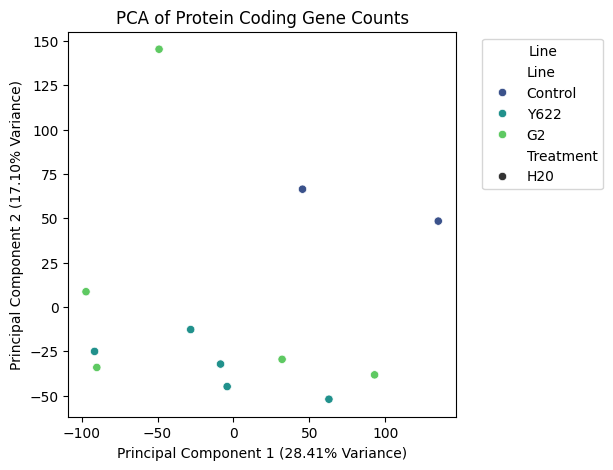

In [46]:
# show PCA; treatment batch 1
batch_1_seqids = metadata[metadata['Notes'].str.contains('batch 1')]['SeqID']
line_seqids = metadata[metadata['Treatment'] == 'H20']['SeqID']
counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding[np.intersect1d(batch_1_seqids, line_seqids)]


# Perform PCA on the counts_cpm_protein_coding
scaler = StandardScaler()
counts_cpm_protein_coding_scaled = scaler.fit_transform(counts_cpm_protein_coding_batch_1.T)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(counts_cpm_protein_coding_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['SeqID'] = counts_cpm_protein_coding_batch_1.columns

pca_df = pd.merge(pca_df, metadata, on='SeqID')

plt.figure(figsize=(5, 5))
sns.scatterplot(x='PC1', y='PC2', hue='Line', style='Treatment', data=pca_df, palette='viridis', edgecolor='w')

# Calculate the explained variance for each principal component
explained_variance = pca.explained_variance_ratio_

plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.2f}% Variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.2f}% Variance)')
plt.title('PCA of Protein Coding Gene Counts')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



In [52]:
treatment_seqids

0     D24-18553
1     D24-18554
2     D24-18555
3     D24-18556
4     D24-18557
5     D24-18558
6     D24-18559
7     D24-18560
8     D24-18561
9     D24-18562
18    D24-18571
19    D24-18572
20    D24-18574
21    D24-18575
22    D24-18576
23    D24-18577
24    D24-18578
25    D24-18580
Name: SeqID, dtype: object

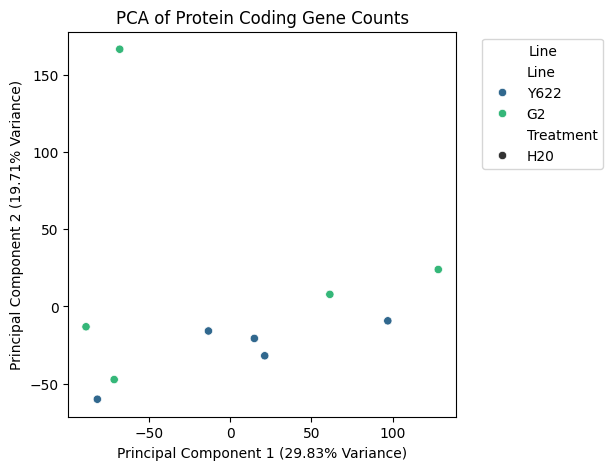

In [54]:
# show PCA; treatment batch 1
batch_1_seqids = metadata[metadata['Notes'].str.contains('batch 1')]['SeqID']
line_seqids = metadata[metadata['Line']!= 'Control']['SeqID']
treatment_seqids = metadata[metadata['Treatment'] == 'H20']['SeqID']
counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding[np.intersect1d(np.intersect1d(batch_1_seqids, line_seqids), (treatment_seqids))]


# Perform PCA on the counts_cpm_protein_coding
scaler = StandardScaler()
counts_cpm_protein_coding_scaled = scaler.fit_transform(counts_cpm_protein_coding_batch_1.T)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(counts_cpm_protein_coding_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['SeqID'] = counts_cpm_protein_coding_batch_1.columns

pca_df = pd.merge(pca_df, metadata, on='SeqID')

plt.figure(figsize=(5, 5))
sns.scatterplot(x='PC1', y='PC2', hue='Line', style='Treatment', data=pca_df, palette='viridis', edgecolor='w')

# Calculate the explained variance for each principal component
explained_variance = pca.explained_variance_ratio_

plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.2f}% Variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.2f}% Variance)')
plt.title('PCA of Protein Coding Gene Counts')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



,PC1,PC2,SeqID,SampleName,Line,Treatment,Vol (ul),Conc,Type,Pool,Genome,Notes
0,-12.617582,-25.462987,D24-18553,E1,Control,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,..."
1,-86.513930,-42.836915,D24-18554,E2,Control,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,..."
2,54.923952,98.041953,D24-18555,Y1,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,..."
3,22.816851,59.733246,D24-18556,Y2,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,..."
4,-12.979081,63.627358,D24-18557,Y3,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,..."
5,0.452243,58.713614,D24-18558,Y4,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,..."
6,-58.348193,37.010624,D24-18559,Y5,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,..."
7,104.683950,-22.701122,D24-18560,Y6,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,diff & extraction batch 2 (2 wells pooled)
8,18.786732,-59.519155,D24-18561,Y7,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,diff & extraction batch 2 (2 wells pooled)
9,42.354146,-58.534927,D24-18562,Y8,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,diff & extraction batch 2 (2 wells pooled)


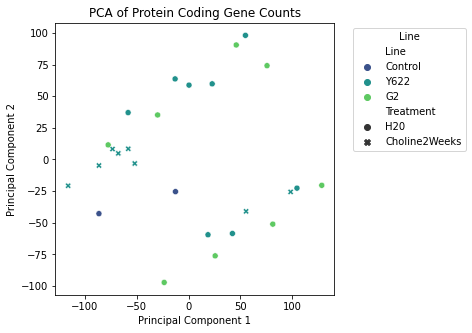

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(5, 5))
sns.scatterplot(x='PC1', y='PC2', hue='Line', style='Treatment', data=pca_df, palette='viridis', edgecolor='w')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Protein Coding Gene Counts')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [1]:
metadata

NameError: name 'metadata' is not defined

In [69]:
metadata

,SampleName,Line,Treatment,Vol (ul),Conc,Type,Pool,Genome,Notes,SeqID
SeqID,,,,,,,,,,
D24-18553,E1,Control,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,...",D24-18553
D24-18554,E2,Control,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,...",D24-18554
D24-18555,Y1,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,...",D24-18555
D24-18556,Y2,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,...",D24-18556
D24-18557,Y3,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,...",D24-18557
D24-18558,Y4,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,...",D24-18558
D24-18559,Y5,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,...",D24-18559
D24-18560,Y6,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,diff & extraction batch 2 (2 wells pooled),D24-18560
D24-18561,Y7,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,diff & extraction batch 2 (2 wells pooled),D24-18561


In [60]:
x = counts_cpm_protein_coding.mean(axis=1).sort_values(ascending=False).index

In [62]:
np.where(x=='ABCA7')

(array([9398]),)